# TAC Depth Discrimination Analysis 

In [1]:
import os 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy 
import scipy.stats as stats
from scipy.stats import sem 
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 


In [2]:
def combineCSVs(datafolder, num_discrim_trials):
    """
    Combine all participant data into one pandas df
    OR 
    Create df for single participant file 
    
    returns:
        (1) combined dataframe of all discrimination data 
        (2) combined dataframe of all scene property rating data 
    """
    #checks if path is a file
    isFile = os.path.isfile(datafolder)

    #checks if path is a directory
    
    isDirectory = os.path.isdir(datafolder)
    
    if isDirectory == True:
        discrim_data = []
        properties_data = []
        for filename in os.listdir(datafolder):
            if 'csv' in filename:
                path = datafolder + "/" + filename
                df = pd.read_csv(path, index_col=None, header=0)
                
                df_discrim = df[0:num_discrim_trials]
                discrim_data.append(df_discrim)
                # row 96 should be ignored - artifact of logging 
                df_properties = df[num_discrim_trials+1:]
                properties_data.append(df_properties)
                

        discrim_frame = pd.concat(discrim_data, axis=0, ignore_index=True)
        properties_frame = pd.concat(properties_data, axis=0, ignore_index=True)
        
    if isFile == True:
        if 'csv' in datafolder:
            df = pd.read_csv(datafolder, index_col=None, header=0)
            df_discrim = df[0:num_discrim_trials]
            discrim_data.append(df_discrim)
            # row 96 should be ignored - artifact of logging 
            df_properties = df[num_discrim_trials+1:]
            properties_data.append(df_properties)
 
    return discrim_frame, properties_frame

In [3]:

# data_path = '/Users/prachimahableshwarkar/Documents/GW/FacialAge/FacialAge_MTurk/BNav_EC2/DepthDuration/v2_depth_discrimination_MTurk/data'

data_path = '/Users/prachi/Documents/depth_duration/target_at_center/january2022_data/discrim_data'


In [4]:
raw_discrim, raw_ratings = combineCSVs(data_path, 100)

In [5]:
all_subjIDs = raw_discrim.subjID.unique()
len(all_subjIDs)

203

In [6]:
raw_discrim

,subjID,experimentName,versionName,sequenceName,url,selected_row,windowWidth,windowHeight,screenWidth,screenHeight,...,trial_RT,log_fixation,log_sceneDuration1,log_mask1,log_sceneDuration2,log_mask2,experimentTime,totalTime,age,gender
0,772183.0,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim1000_randls_33.json,http://54.173.230.142/FacialAge/BNav_EC2/Depth...,75.0,1366.0,625.0,1366.0,768.0,...,2248.0,1012.0,997.0,990.0,1023.0,480.0,NaN,367847,30,Woman
1,772183.0,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim1000_randls_33.json,http://54.173.230.142/FacialAge/BNav_EC2/Depth...,75.0,1366.0,625.0,1366.0,768.0,...,2259.0,1012.0,997.0,990.0,1023.0,480.0,NaN,367847,30,Woman
2,772183.0,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim1000_randls_33.json,http://54.173.230.142/FacialAge/BNav_EC2/Depth...,75.0,1366.0,625.0,1366.0,768.0,...,5465.0,1003.0,1016.0,998.0,982.0,502.0,NaN,367847,30,Woman
3,772183.0,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim1000_randls_33.json,http://54.173.230.142/FacialAge/BNav_EC2/Depth...,75.0,1366.0,625.0,1366.0,768.0,...,5473.0,1003.0,1016.0,998.0,982.0,502.0,NaN,367847,30,Woman
4,772183.0,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim1000_randls_33.json,http://54.173.230.142/FacialAge/BNav_EC2/Depth...,75.0,1366.0,625.0,1366.0,768.0,...,5475.0,1003.0,1016.0,998.0,982.0,502.0,NaN,367847,30,Woman
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20295,111793.0,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim1000_randls_39.json,http://54.173.230.142/FacialAge/BNav_EC2/Depth...,88.0,1920.0,902.0,1536.0,864.0,...,3178.0,1011.0,994.0,1003.0,996.0,512.0,NaN,837666,27,Woman
20296,111793.0,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim1000_randls_39.json,http://54.173.230.142/FacialAge/BNav_EC2/Depth...,88.0,1920.0,902.0,1536.0,864.0,...,5625.0,1008.0,1005.0,991.0,1009.0,496.0,NaN,837666,27,Woman
20297,111793.0,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim1000_randls_39.json,http://54.173.230.142/FacialAge/BNav_EC2/Depth...,88.0,1920.0,902.0,1536.0,864.0,...,2707.0,1015.0,989.0,1000.0,1001.0,510.0,NaN,837666,27,Woman
20298,111793.0,DepthScenes,v2_duration_discrimination,discrim_jsons/Discrim1000_randls_39.json,http://54.173.230.142/FacialAge/BNav_EC2/Depth...,88.0,1920.0,902.0,1536.0,864.0,...,3132.0,1015.0,994.0,1005.0,988.0,503.0,NaN,837666,27,Woman


In [7]:
all_ages = raw_discrim.age.unique()
all_ages

array([30, 35, 53, 43, 59, 37, 29, 62, 28, 45, 32, 50, 56, 40, 31, 25, 63,
       38, 60, 36, 33, 27, 58, 44, 34, 49, 55, 52, 24, 46, 57, 41, 67, 47,
       39, 26, 54, 42, 48, 51, 23, 71])

## <font color='red'> Data Cleaning </font> 



In [8]:
def catchTrial_cleaning(df, correct_requirement, catch_stimuli):
    '''
    Participants complete 8 catch trials total to ensure that they are doing the task.
    If less than 7/8 catch trials are correct, the participant is excluded.  
    '''
    all_subjIDs = df.subjID.unique()
    remove = []
    subj_sequence = {}
    df2_list = []
    sequence_count = {'discrim_jsons/Discrim250_randls_33.json': 0,
 'discrim_jsons/Discrim250_randls_25.json': 0,
 'discrim_jsons/Discrim250_randls_44.json': 0,
 'discrim_jsons/Discrim250_randls_13.json': 0,
 'discrim_jsons/Discrim250_randls_7.json': 0,
 'discrim_jsons/Discrim250_randls_29.json': 0,
 'discrim_jsons/Discrim250_randls_28.json': 0,
 'discrim_jsons/Discrim250_randls_6.json': 0,
 'discrim_jsons/Discrim250_randls_12.json': 0,
 'discrim_jsons/Discrim250_randls_45.json': 0,
 'discrim_jsons/Discrim250_randls_24.json': 0,
 'discrim_jsons/Discrim250_randls_32.json': 0,
 'discrim_jsons/Discrim250_randls_42.json': 0,
 'discrim_jsons/Discrim250_randls_15.json': 0,
 'discrim_jsons/Discrim250_randls_39.json': 0,
 'discrim_jsons/Discrim250_randls_1.json': 0,
 'discrim_jsons/Discrim250_randls_19.json': 0,
 'discrim_jsons/Discrim250_randls_35.json': 0,
 'discrim_jsons/Discrim250_randls_23.json': 0,
 'discrim_jsons/Discrim250_randls_22.json': 0,
 'discrim_jsons/Discrim250_randls_34.json': 0,
 'discrim_jsons/Discrim250_randls_18.json': 0,
 'discrim_jsons/Discrim250_randls_38.json': 0,
 'discrim_jsons/Discrim250_randls_0.json': 0,
 'discrim_jsons/Discrim250_randls_14.json': 0,
 'discrim_jsons/Discrim250_randls_43.json': 0,
 'discrim_jsons/Discrim250_randls_3.json': 0,
 'discrim_jsons/Discrim250_randls_17.json': 0,
 'discrim_jsons/Discrim250_randls_40.json': 0,
 'discrim_jsons/Discrim250_randls_21.json': 0,
 'discrim_jsons/Discrim250_randls_37.json': 0,
 'discrim_jsons/Discrim250_randls_36.json': 0,
 'discrim_jsons/Discrim250_randls_20.json': 0,
 'discrim_jsons/Discrim250_randls_41.json': 0,
 'discrim_jsons/Discrim250_randls_16.json': 0,
 'discrim_jsons/Discrim250_randls_2.json': 0,
 'discrim_jsons/Discrim250_randls_27.json': 0,
 'discrim_jsons/Discrim250_randls_9.json': 0,
 'discrim_jsons/Discrim250_randls_31.json': 0,
 'discrim_jsons/Discrim250_randls_5.json': 0,
 'discrim_jsons/Discrim250_randls_11.json': 0,
 'discrim_jsons/Discrim250_randls_46.json': 0,
 'discrim_jsons/Discrim250_randls_10.json': 0,
 'discrim_jsons/Discrim250_randls_4.json': 0,
 'discrim_jsons/Discrim250_randls_8.json': 0,
 'discrim_jsons/Discrim250_randls_30.json': 0,
 'discrim_jsons/Discrim250_randls_26.json': 0,
 'discrim_jsons/Discrim1000_randls_20.json': 0,
 'discrim_jsons/Discrim1000_randls_7.json': 0,
 'discrim_jsons/Discrim1000_randls_36.json': 0,
 'discrim_jsons/Discrim1000_randls_41.json': 0,
 'discrim_jsons/Discrim1000_randls_16.json': 0,
 'discrim_jsons/Discrim1000_randls_17.json': 0,
 'discrim_jsons/Discrim1000_randls_40.json': 0,
 'discrim_jsons/Discrim1000_randls_37.json': 0,
 'discrim_jsons/Discrim1000_randls_6.json': 0,
 'discrim_jsons/Discrim1000_randls_21.json': 0,
 'discrim_jsons/Discrim1000_randls_10.json': 0,
 'discrim_jsons/Discrim1000_randls_26.json': 0,
 'discrim_jsons/Discrim1000_randls_1.json': 0,
 'discrim_jsons/Discrim1000_randls_30.json': 0,
 'discrim_jsons/Discrim1000_randls_31.json': 0,
 'discrim_jsons/Discrim1000_randls_0.json': 0,
 'discrim_jsons/Discrim1000_randls_27.json': 0,
 'discrim_jsons/Discrim1000_randls_11.json': 0,
 'discrim_jsons/Discrim1000_randls_46.json': 0,
 'discrim_jsons/Discrim1000_randls_12.json': 0,
 'discrim_jsons/Discrim1000_randls_45.json': 0,
 'discrim_jsons/Discrim1000_randls_28.json': 0,
 'discrim_jsons/Discrim1000_randls_32.json': 0,
 'discrim_jsons/Discrim1000_randls_3.json': 0,
 'discrim_jsons/Discrim1000_randls_24.json': 0,
 'discrim_jsons/Discrim1000_randls_25.json': 0,
 'discrim_jsons/Discrim1000_randls_2.json': 0,
 'discrim_jsons/Discrim1000_randls_33.json': 0,
 'discrim_jsons/Discrim1000_randls_29.json': 0,
 'discrim_jsons/Discrim1000_randls_44.json': 0,
 'discrim_jsons/Discrim1000_randls_13.json': 0,
 'discrim_jsons/Discrim1000_randls_18.json': 0,
 'discrim_jsons/Discrim1000_randls_34.json': 0,
 'discrim_jsons/Discrim1000_randls_5.json': 0,
 'discrim_jsons/Discrim1000_randls_22.json': 0,
 'discrim_jsons/Discrim1000_randls_14.json': 0,
 'discrim_jsons/Discrim1000_randls_43.json': 0,
 'discrim_jsons/Discrim1000_randls_38.json': 0,
 'discrim_jsons/Discrim1000_randls_9.json': 0,
 'discrim_jsons/Discrim1000_randls_8.json': 0,
 'discrim_jsons/Discrim1000_randls_39.json': 0,
 'discrim_jsons/Discrim1000_randls_42.json': 0,
 'discrim_jsons/Discrim1000_randls_15.json': 0,
 'discrim_jsons/Discrim1000_randls_23.json': 0,
 'discrim_jsons/Discrim1000_randls_4.json': 0,
 'discrim_jsons/Discrim1000_randls_35.json': 0,
 'discrim_jsons/Discrim1000_randls_19.json': 0}
    for subj in all_subjIDs:
#         print(subj)
        count_correct = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        # 
        subj_sequence[subj] = subj_df.sequenceName.unique()[0]
        
        # remove trials that are outside the outlier range
        c = 0
        c_missed = 0
        for idx, row in subj_df.iterrows():
            stim1 = row['stimulus_0']
            stim2 = row['stimulus_1']
            # TEMP SOLUTION FOR RANDOM PHP DATA SAVING PROBLEM 
            if type(stim1) == str:
                if stim1.split('/')[1] in catch_stimuli or stim2.split('/')[1] in catch_stimuli:
                    ####### VERSION WHERE CATCH TRIALS ARE ATTENTION CHECK: IMAGE 1 IS THE SAME AS IMAGE 2
                    c += 1
                    if row["discrim_choice"] == 3:
#                         print(row["discrim_choice"])
                        count_correct += 1
#                     else:
#                         print(row["discrim_choice"])
                    # remove catch trial 
                    cleaned_subj_df.drop([idx], inplace=True)
    #                 print(depth0, depth1, correct_choice, choice)
#         print(c_missed, 'Number of catch trials where participants did not see the target')
#         print(c)
#         print(count_correct)
        if count_correct < correct_requirement:
#             print('Number correct:', count_correct)
            remove.append(subj)
        else:
            sequence_count[subj_df.sequenceName.unique()[0]] += 1
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of participants that did not pass the catch trial check:", len(remove))
    print("Participants that were removed:",remove)
    print("Sequences that need to be replaced:")
#     for subj in remove:
#         print(subj_sequence[subj])
    print("Sequence count:")
    print(sequence_count)
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2
    
    
    

In [9]:
# all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
#               '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
#               '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
#               '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
#               '002364_2014-06-28_20-11-05_260595134347_rgbf000042-resize_0',
#               '002675_2014-06-13_16-08-49_094959634447_rgbf000151-resize_2',
#               '003125_2014-05-12_10-39-22_094959634447_rgbf000100-resize_0',
#               '003395_2014-05-20_15-39-18_094959634447_rgbf000101-resize_0',
#               '000454_2014-06-08_16-37-28_260595134347_rgbf000048-resize_2',
#               '000868_2014-06-09_20-49-52_260595134347_rgbf000064-resize_4',
#               '000953_2014-06-08_11-42-19_260595134347_rgbf000083-resize_0',
#               '001012_2014-06-08_23-19-38_260595134347_rgbf000057-resize_0',
#               '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
#               '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
#               '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
#               '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']


all_catch_stim = ['000375_2014-06-08_11-17-29_260595134347_rgbf000133-resize_2',
                  '000569_2014-06-09_22-51-47_260595134347_rgbf000141-resize_3',
                  '000787_2014-06-08_22-33-53_260595134347_rgbf000175-resize_1',
                  '002072_2014-06-24_21-48-06_260595134347_rgbf000115-resize_0',
                  '001170_2014-06-17_15-43-44_260595134347_rgbf000096-resize_6',
                  '001222_2014-06-17_16-24-06_260595134347_rgbf000073-resize_0',
                  '001498_2014-06-19_17-45-14_260595134347_rgbf000129-resize_4',
                  '001540_2014-06-20_17-01-05_260595134347_rgbf000086-resize_2']

In [10]:
catch_cleaned_discrim = catchTrial_cleaning(raw_discrim, 7, all_catch_stim)

Number of participants that did not pass the catch trial check: 112
Participants that were removed: [772183.0, 838816.0, 401746.0, 580863.0, 168006.0, 402710.0, 106558.0, 928209.0, 578519.0, 973883.0, 257946.0, 446835.0, 533644.0, 630281.0, 476553.0, 363571.0, 871257.0, 835724.0, 169133.0, 265550.0, 280126.0, 587123.0, 738295.0, 705649.0, 172931.0, 653628.0, 764353.0, 596798.0, 580281.0, 769034.0, 615459.0, 773532.0, 939462.0, 270605.0, 250927.0, 479907.0, 852717.0, 628938.0, 723399.0, 968335.0, 670189.0, 493741.0, 488643.0, 200784.0, 188346.0, 509453.0, 617406.0, 595691.0, 110296.0, 858027.0, 537762.0, 551830.0, 494974.0, 268229.0, 822232.0, 782613.0, 723057.0, 920203.0, 916710.0, 382321.0, 988872.0, 589703.0, 134718.0, 661574.0, 368727.0, 126003.0, 425814.0, 857609.0, 129631.0, 309644.0, 952703.0, 711217.0, 685597.0, 902310.0, 520915.0, 124831.0, 100067.0, 449862.0, 151527.0, 109287.0, 231985.0, 238865.0, 138566.0, 853661.0, 216777.0, 612756.0, 974672.0, 836975.0, 315730.0, 915553.0,

In [11]:
cleaned_ages = catch_cleaned_discrim.age.unique()
cleaned_ages

array([35, 53, 43, 59, 37, 28, 45, 50, 40, 32, 30, 31, 33, 27, 44, 34, 49,
       55, 46, 58, 41, 29, 25, 38, 67, 57, 24, 60, 56, 47, 26, 42, 63, 48,
       51])

In [12]:
def RT_cleaning(df, outlier_range, num_trials):
    all_subjIDs = df.subjID.unique()
    remove = []
    df2_list = []
    for subj in all_subjIDs:
        count = 0
        subj_df = df.loc[df['subjID'] == subj]
        cleaned_subj_df = subj_df.copy(deep=True) # prevent setting with copy warning
        
        # calculate subject's average trial RT
        average_trial_RT = subj_df["trial_RT"].mean()
        std_trial_RT = subj_df["trial_RT"].std()
        p_outlier_range = [(average_trial_RT - (3*std_trial_RT)), (average_trial_RT + (3*std_trial_RT))]
        
        # remove trials that are outside the outlier range
        for idx, row in subj_df.iterrows():
            RT = row['trial_RT']
            if RT < outlier_range[0]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            if RT > outlier_range[1]:
                cleaned_subj_df.drop([idx], inplace=True)
                count += 1
            try:
                if RT < p_outlier_range[0]:
                    cleaned_subj_df.drop([idx], inplace=True)
                    count += 1
                if RT > p_outlier_range[1]:
                    cleaned_subj_df.drop([idx], inplace=True)
                    count += 1
            except:
                print("Trial already removed")
                
        threshold = math.floor(num_trials * 0.1)
        if count >= threshold:
            remove.append(subj)
        
        df2_list.append(cleaned_subj_df)
    
    df2 = pd.concat(df2_list)
    print("Number of Participants with 10% or more trials outside their RT range:", len(remove))
    
    for index, row in df2.iterrows():
        if row['subjID'] in remove:
            df2.drop(index, inplace=True)
    
    return df2


In [13]:
cleaned_discrim = RT_cleaning(catch_cleaned_discrim, [250,5000], 94)


# cleaned_discrim = RT_cleaning(catch_cleaned_discrim, [250,5000], 32)

Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Trial already removed
Number of Participants with 10% or more trials outside their RT range: 3


In [14]:
def finalTrialCountCheck(df, num_trials):
    """
    If more then 10% of a participants data is missing, remove the participant
    """
    #List unique values in the df['subjID'] column\n",
    all_subjIDs = df.subjID.unique()
    remove = []
    for subj in all_subjIDs:
        subj_df = df.loc[df['subjID'] == subj]
        count_trials = len(subj_df.index)
        threshold_trials_remaining = num_trials - math.floor(num_trials * 0.1)
        
        if count_trials <= threshold_trials_remaining:
            remove.append(subj)
    print("Number of Participants with >= 10% trials removed:", len(remove))
    
    for index, row in df.iterrows():
        if row['subjID'] in remove:
            df.drop(index, inplace=True)
    
    print("Number of participants left:",len(df.subjID.unique()))
    
    return df

In [15]:
final_discrim = finalTrialCountCheck(cleaned_discrim, 94)

Number of Participants with >= 10% trials removed: 1
Number of participants left: 87


## Sequences that need replacing

Final N = 192 

Each sequence should have 48 participants

In [16]:
sequence_count = {}
for subj in final_discrim.subjID.unique():
    subj_df = final_discrim.loc[final_discrim['subjID'] == subj]
    sequence = subj_df.sequenceName.unique()[0]
    if sequence not in sequence_count.keys():
        sequence_count[sequence] = 1
    else:
        sequence_count[sequence] += 1
        
sequence_count

{'discrim_jsons/Discrim250_randls_45.json': 1,
 'discrim_jsons/Discrim250_randls_32.json': 1,
 'discrim_jsons/Discrim250_randls_6.json': 1,
 'discrim_jsons/Discrim250_randls_4.json': 1,
 'discrim_jsons/Discrim1000_randls_16.json': 1,
 'discrim_jsons/Discrim250_randls_39.json': 1,
 'discrim_jsons/Discrim1000_randls_26.json': 1,
 'discrim_jsons/Discrim1000_randls_35.json': 1,
 'discrim_jsons/Discrim1000_randls_18.json': 1,
 'discrim_jsons/Discrim1000_randls_5.json': 1,
 'discrim_jsons/Discrim1000_randls_10.json': 1,
 'discrim_jsons/Discrim1000_randls_2.json': 1,
 'discrim_jsons/Discrim1000_randls_30.json': 1,
 'discrim_jsons/Discrim1000_randls_3.json': 1,
 'discrim_jsons/Discrim1000_randls_7.json': 1,
 'discrim_jsons/Discrim1000_randls_15.json': 1,
 'discrim_jsons/Discrim250_randls_46.json': 1,
 'discrim_jsons/Discrim250_randls_10.json': 1,
 'discrim_jsons/Discrim250_randls_35.json': 1,
 'discrim_jsons/Discrim1000_randls_28.json': 1,
 'discrim_jsons/Discrim1000_randls_14.json': 1,
 'disc

Need to collect:

* 'discrim_jsons/v2_shuffled_g0_rotated.json': 8,
* 'discrim_jsons/v2_shuffled_g0.json': 11,
* 'discrim_jsons/v2_shuffled_g0_dr.json': 8,
* 'discrim_jsons/v2_shuffled_g0_rotated_dr.json': 7

## Accuracy

In [17]:
def get_accuracy(df):
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    for idx, row in df.iterrows():
        choice = row["discrim_choice"]
        if choice == 2.0:
            count_missed += 1
        else:    
            count_total += 1
            depth0 = row["actual_depth_0"]
            depth1 = row["actual_depth_1"]
            if depth0 < depth1:
                correct_choice = 0
            if depth0 > depth1:
                correct_choice = 1
            if depth0 == depth1:
                # case where depths are equal 
                correct_choice = None
            if choice == correct_choice:
                count_correct += 1
    if count_total == 0:
        return count_correct
    else:
#         standardError = (0.5*(1-0.5))/count_total
        p = count_correct/count_total
        standardError = np.sqrt((p*(1-p))/count_total)
    

    return count_correct/count_total, count_correct, count_total, count_missed, standardError

In [18]:
overall_accuracy = get_accuracy(final_discrim)
overall_accuracy

(0.6856046065259117, 5358, 7815, 21, 0.005251827577417725)

#### Accuracy by Duration

In [19]:
discrim_250ms = final_discrim[final_discrim['duration'] == 250]
discrim_1000ms = final_discrim[final_discrim['duration'] == 1000]

In [20]:
accuracy_250 = get_accuracy(discrim_250ms)
accuracy_1000 = get_accuracy(discrim_1000ms)
accuracy_250, accuracy_1000

((0.6807026608111599, 2635, 3871, 12, 0.007493156239895586),
 (0.6904158215010142, 2723, 3944, 9, 0.007361669113760163))

#### Accuracy by Duration and Depth Bin

In [21]:
investigate = []

In [22]:
depth_bins = np.arange(1,5,1)
depth_bins_accuracy_250 = {}
depth_bins_accuracy_1000 = {}

for _bin in depth_bins:
    bin_df = final_discrim[(final_discrim['actual_depth_0'] >= _bin) & (final_discrim['actual_depth_0'] < _bin + 1)]
    bin_df_250ms = bin_df[bin_df['duration'] == 250.0]
    bin_df_1000ms = bin_df[bin_df['duration'] == 1000.0]
    print(bin_df_250ms.shape)
    print(bin_df_1000ms.shape)
    
    acc_250 = get_accuracy(bin_df_250ms)
    acc_1000 = get_accuracy(bin_df_1000ms)
    
    if acc_1000[0] < 0.5:
        investigate.append(bin_df_1000ms)
    
    depth_bins_accuracy_250[round(_bin, 3)] = acc_250[0]
    depth_bins_accuracy_1000[round(_bin, 3)] = acc_1000[0]


(913, 29)
(922, 29)
(1198, 29)
(1224, 29)
(607, 29)
(631, 29)
(1165, 29)
(1176, 29)


In [23]:
len(investigate)

0

In [24]:
investigate[0][['subjID', 'stimulus_0', 'actual_depth_0', 'stimulus_1', 'actual_depth_1', 'discrim_choice']]

IndexError: list index out of range

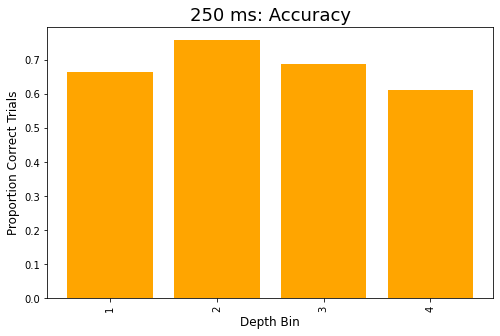

In [25]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_bins_accuracy_250)), list(depth_bins_accuracy_250.values()), align='center', color = 'orange')
plt.xticks(range(len(depth_bins_accuracy_250)), list(depth_bins_accuracy_250.keys()), rotation=90)
plt.xlabel("Depth Bin", fontsize = 12)
plt.ylabel("Proportion Correct Trials", fontsize = 12)
plt.title("250 ms: Accuracy", fontsize = 18)
plt.show()

In [26]:
# depthbin_2m = final_discrim[(final_discrim['actual_depth_0'] >= 2) & (final_discrim['actual_depth_0'] < _bin + 0.2)]

# depthbin_stim0 = []
# depthbin_stim1 = []
# depthbin_depthdiff = []
# for index, row in depthbin_2m.iterrows():
#     depthbin_stim0.append(row['stimulus_0'])
#     depthbin_stim1.append(row['stimulus_1'])
#     depthbin_depthdiff.append(abs(row['actual_depth_0'] - row['actual_depth_1']))
    

In [27]:
# i = 10
# depthbin_stim0[i], depthbin_stim1[i], depthbin_depthdiff[i]


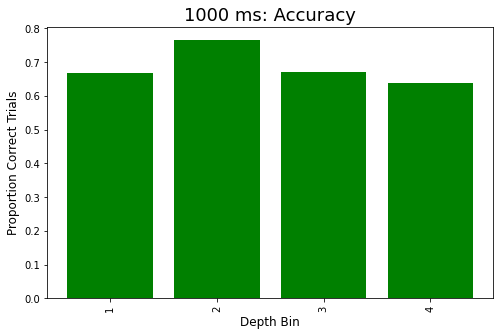

In [28]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_bins_accuracy_1000)), list(depth_bins_accuracy_1000.values()), align='center', color = 'green')
plt.xticks(range(len(depth_bins_accuracy_1000)), list(depth_bins_accuracy_1000.keys()), rotation=90)
plt.xlabel("Depth Bin", fontsize = 12)
plt.ylabel("Proportion Correct Trials", fontsize = 12)
plt.title("1000 ms: Accuracy", fontsize = 18)
plt.show()


#### Proportion Correct as a Function of Amount of Depth Difference

In [29]:
def depth_differences(df):
    """
    args:
        df  
    returns:
        array of depth differences, avg depth differences and std   
    """
    depth_diffs = []
    for idx, row in df.iterrows():
        depth0 = row["actual_depth_0"]
        depth1 = row["actual_depth_1"]
        
        diff = abs(depth0-depth1)
        depth_diffs.append(diff)
    
    depth_diffs = np.array(depth_diffs)
    
    return depth_diffs, np.mean(depth_diffs) ,np.std(depth_diffs)
    

In [30]:
all_depth_diffs = depth_differences(final_discrim)

# add depth difference column to dataframe 
final_discrim.insert(18, "depth_difference", all_depth_diffs[0])

In [31]:
final_discrim["depth_difference"]

100      0.38650
101      1.16000
102      0.47650
103      1.01450
105      1.07100
          ...   
19795    0.61550
19796    0.72200
19797    0.30150
19798    1.05375
19799    1.16400
Name: depth_difference, Length: 7836, dtype: float64

Mean & Std:  (0.6878909466989964, 0.28653163045013563)


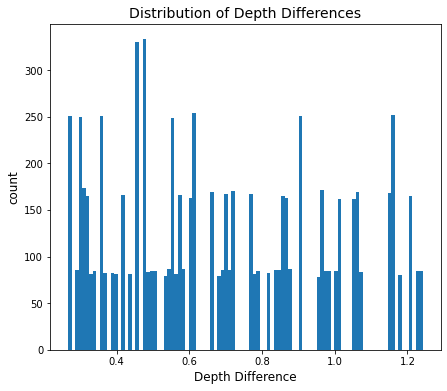

(1.2429999999999999, 0.266)

In [32]:
print("Mean & Std: ", all_depth_diffs[1:])
plt.figure(figsize = [7,6])
plt.hist(all_depth_diffs[0], bins=100)
plt.title("Distribution of Depth Differences", fontsize = 14)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("count", fontsize = 12)
plt.show()
np.amax(all_depth_diffs[0]), np.amin(all_depth_diffs[0])

In [33]:
# individual discrimination code 

In [34]:
depth_diffs = np.arange(0.24,0.54, 0.04)


depth_diff_accuracy_250 = {}
depth_diff_accuracy_1000 = {}

for diff in depth_diffs:
    diff_bin_df = final_discrim[(final_discrim['depth_difference'] >= diff) & (final_discrim['depth_difference'] < diff + 0.04)]
    diff_bin_df_250ms = diff_bin_df[diff_bin_df['duration'] == 250.0]
    diff_bin_df_1000ms = diff_bin_df[diff_bin_df['duration'] == 1000.0]

    
    diff_acc_250 = get_accuracy(diff_bin_df_250ms)
    diff_acc_1000 = get_accuracy(diff_bin_df_1000ms)
    
    depth_diff_accuracy_250[round(diff, 3)] = diff_acc_250[0]
    depth_diff_accuracy_1000[round(diff, 3)] = diff_acc_1000[0]
    

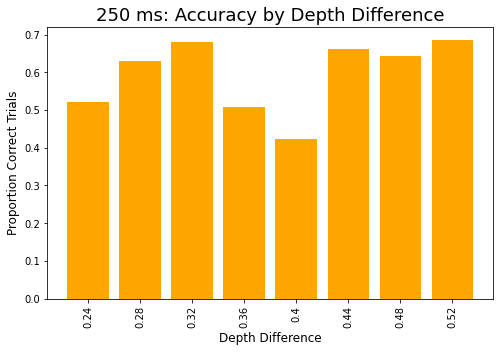

In [35]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_diff_accuracy_250)), list(depth_diff_accuracy_250.values()), color = 'orange')
plt.xticks(range(len(depth_diff_accuracy_250)), list(depth_diff_accuracy_250.keys()), rotation=90)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("Proportion Correct Trials", fontsize = 12)
plt.title("250 ms: Accuracy by Depth Difference", fontsize = 18)
plt.show()

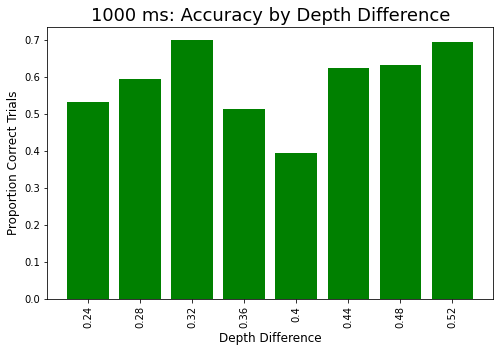

In [36]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_diff_accuracy_1000)), list(depth_diff_accuracy_1000.values()), color = 'green')
plt.xticks(range(len(depth_diff_accuracy_1000)), list(depth_diff_accuracy_1000.keys()), rotation=90)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("Proportion Correct Trials", fontsize = 12)
plt.title("1000 ms: Accuracy by Depth Difference", fontsize = 18)
plt.show()

## Reaction Time

In [37]:
def get_RT(df):
    """
    args:
        df  
    returns:
        array of RTs, avg RT and std   
    """
    list_RTs = []
    for idx, row in df.iterrows():   
        stimulus_duration = row['log_sceneDuration2']
        RT = row["trial_RT"] - stimulus_duration
        list_RTs.append(RT)
    
    if len(list_RTs) < 2:
        return list_RTs
    else:
        list_RTs = np.array(list_RTs)
        return list_RTs, np.mean(list_RTs) ,np.std(list_RTs), stats.sem(list_RTs)

Mean & Std:  (1114.7087799897906, 420.6397773467965, 4.752157636937169)


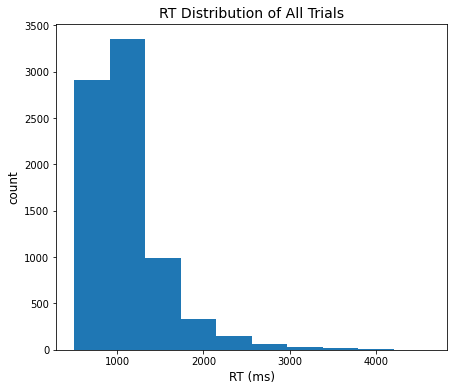

In [38]:
overall_RT = get_RT(final_discrim)
print("Mean & Std: ", overall_RT[1:])
plt.figure(figsize = [7,6])
plt.hist(overall_RT[0])
plt.title("RT Distribution of All Trials", fontsize = 14)
plt.xlabel("RT (ms)", fontsize = 12)
plt.ylabel("count", fontsize = 12)
plt.show()

In [39]:
RT_250 = get_RT(discrim_250ms)
RT_1000 = get_RT(discrim_1000ms)


Mean & Std:  (1163.9616276075199, 441.1684948117341, 7.080708653603146)


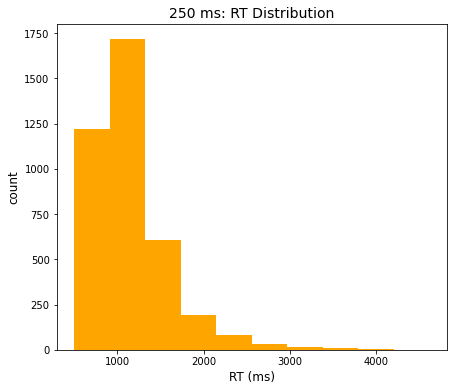

In [40]:
print("Mean & Std: ", RT_250[1:])
plt.figure(figsize = [7,6])
plt.hist(RT_250[0], color="orange")
plt.title("250 ms: RT Distribution", fontsize = 14)
plt.xlabel("RT (ms)", fontsize = 12)
plt.ylabel("count", fontsize = 12)
plt.show()

Mean & Std:  (1066.3281052365292, 393.4916975301676, 6.259319287397977)


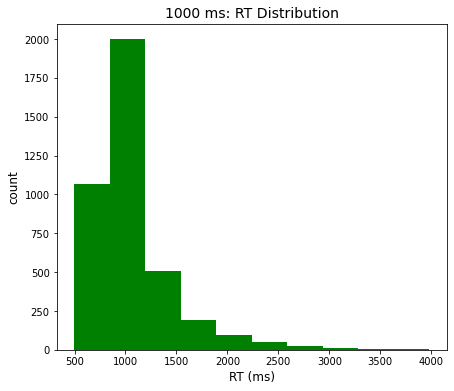

In [41]:
print("Mean & Std: ", RT_1000[1:])
plt.figure(figsize = [7,6])
plt.hist(RT_1000[0], color="green")
plt.title("1000 ms: RT Distribution", fontsize = 14)
plt.xlabel("RT (ms)", fontsize = 12)
plt.ylabel("count", fontsize = 12)
plt.show()

In [42]:
depth_bins = np.arange(1,5,0.4)
depth_bins_avgRT_250 = {}
depth_bins_stdRT_250 = {}
depth_bins_avgRT_1000 = {}
depth_bins_stdRT_1000 = {}


for _bin in depth_bins:
    bin_df = final_discrim[(final_discrim['actual_depth_0'] >= _bin) & (final_discrim['actual_depth_0'] < _bin + 0.4)]
    bin_df_250ms = bin_df[bin_df['duration'] == 250.0]
    bin_df_1000ms = bin_df[bin_df['duration'] == 1000.0]
    
    _RT_250 = get_RT(bin_df_250ms)
    _RT_1000 = get_RT(bin_df_1000ms)
    
    depth_bins_avgRT_250[round(_bin, 3)] = _RT_250[1]
    depth_bins_stdRT_250[round(_bin,3)] = _RT_250[2]
    depth_bins_avgRT_1000[round(_bin, 3)] = _RT_1000[1]
    depth_bins_stdRT_1000[round(_bin,3)] = _RT_1000[2]


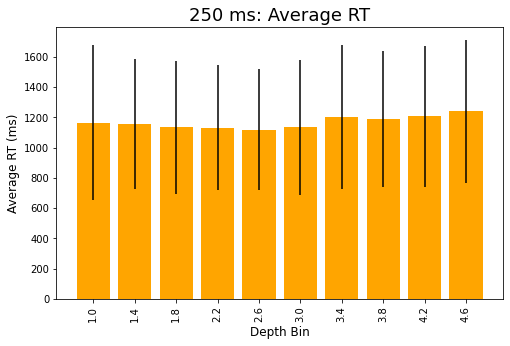

In [43]:
plt.figure(figsize = [8, 5])

plt.bar(range(len(depth_bins_avgRT_250)), list(depth_bins_avgRT_250.values()), align='center', color = 'orange',
        yerr = list(depth_bins_stdRT_250.values()))

plt.xticks(range(len(depth_bins_avgRT_250)), list(depth_bins_avgRT_250.keys()), rotation=90)
plt.xlabel("Depth Bin", fontsize = 12)
plt.ylabel("Average RT (ms)", fontsize = 12)
plt.title("250 ms: Average RT", fontsize = 18)
plt.show()

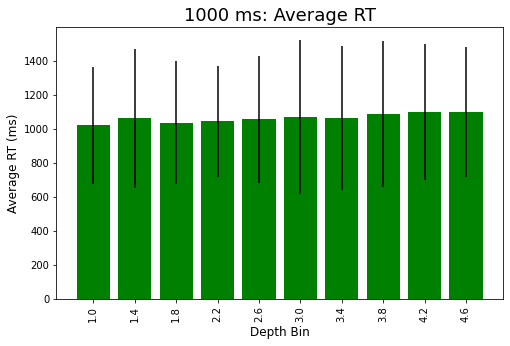

In [44]:
plt.figure(figsize = [8, 5])

plt.bar(range(len(depth_bins_avgRT_1000)), list(depth_bins_avgRT_1000.values()), align='center', color = 'green',
        yerr = list(depth_bins_stdRT_1000.values()))

plt.xticks(range(len(depth_bins_avgRT_1000)), list(depth_bins_avgRT_1000.keys()), rotation=90)
plt.xlabel("Depth Bin", fontsize = 12)
plt.ylabel("Average RT (ms)", fontsize = 12)
plt.title("1000 ms: Average RT", fontsize = 18)
plt.show()

In [45]:
depth_diffs = np.arange(0.24,0.54, 0.04)

depth_diff_RT_250 = {}
depth_diff_RT_1000 = {}

for diff in depth_diffs:
    diff_bin_df = final_discrim[(final_discrim['depth_difference'] >= diff) & (final_discrim['depth_difference'] < diff + 0.04)]
    diff_bin_df_250ms = diff_bin_df[diff_bin_df['duration'] == 250.0]
    diff_bin_df_1000ms = diff_bin_df[diff_bin_df['duration'] == 1000.0]
    
    diff_RT_250 = get_RT(diff_bin_df_250ms)
    diff_RT_1000 = get_RT(diff_bin_df_1000ms)
    
    depth_diff_RT_250[round(diff, 3)] = diff_RT_250[1]
    depth_diff_RT_1000[round(diff, 3)] = diff_RT_1000[1]
    

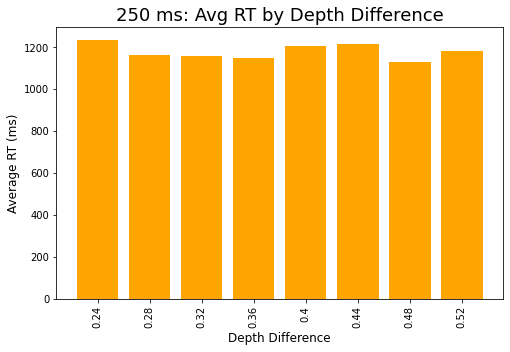

In [46]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_diff_RT_250)), list(depth_diff_RT_250.values()), color = 'orange')
plt.xticks(range(len(depth_diff_RT_250)), list(depth_diff_RT_250.keys()), rotation=90)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("Average RT (ms)", fontsize = 12)
plt.title("250 ms: Avg RT by Depth Difference", fontsize = 18)
plt.show()

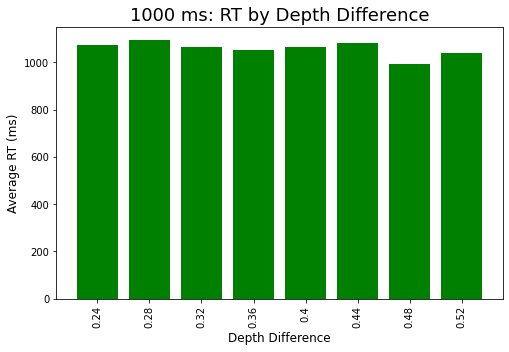

In [47]:
plt.figure(figsize = [8, 5])
plt.bar(range(len(depth_diff_RT_1000)), list(depth_diff_RT_1000.values()), color = 'green')
plt.xticks(range(len(depth_diff_RT_1000)), list(depth_diff_RT_1000.keys()), rotation=90)
plt.xlabel("Depth Difference", fontsize = 12)
plt.ylabel("Average RT (ms)", fontsize = 12)
plt.title("1000 ms: RT by Depth Difference", fontsize = 18)
plt.show()

## Individual Discriminations

In [48]:
def individual_discrimination_stats(df):
    '''
    Individual discrimination performance and RT 
    '''
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
        
        stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        stim_acc_250 = get_accuracy(stim_250_df)
        stim_acc_1000 = get_accuracy(stim_1000_df)
        
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)
        
        stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                'accuracy_250': stim_acc_250,
                                'accuracy_1000': stim_acc_1000,
                                'avg_depth': stim_depthbin,
                                'depthdifference': stim_depthdiff, 
                                'RT_250': stim_RT_250,
                                'RT_1000': stim_RT_1000}
    
    return stimuli_stats

In [49]:
all_discrim_performance = individual_discrimination_stats(final_discrim)


In [50]:
all_subjs = final_discrim.subjID.unique()

subjs_PC_250 = []
subjs_PC_1000 = []
subjs_avgRT_250 = []
subjs_avgRT_1000 = []

for subj in all_subjs:
    subjdf = final_discrim.loc[final_discrim['subjID'] == subj]
    
    all_stim0 = subjdf.stimulus_0.unique()
    
    subj_correctcount_250 = 0
    subj_correctcount_1000 = 0
    subj_RTs_250 = []
    subj_RTs_1000 = []
    
    stimuli_stats = {}
    total = 0
    for stim0 in all_stim0:
        stim0_df = subjdf.loc[subjdf['stimulus_0'] == stim0]
        other_stim = stim0_df.stimulus_1.unique()[0]
        stim1_df = subjdf.loc[subjdf['stimulus_1'] == stim0]
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
        
        stim_depthdiff = stim_df['depth_difference'][0]
        try:
            stim_acc_250 = get_accuracy(stim_250_df)[0]
            total += 1
        except:
            pass
        subj_correctcount_250 += stim_acc_250
        try:
            stim_acc_1000 = get_accuracy(stim_1000_df)[0]
            total += 1
        except: 
            pass
        subj_correctcount_1000 += stim_acc_1000
#         try:
#             subj_RTs_250.append(get_RT(stim_250_df)[0])
#         except:
#             pass
#         try:
#             subj_RTs_1000.append(get_RT(stim_1000_df)[0])
#         except:
#             pass
        
#         stimuli_stats[stim0] = {'stimulus_1': other_stim,
#                                 'accuracy_250': stim_acc_250,
#                                 'accuracy_1000': stim_acc_1000,
#                                 'depthdifference': stim_depthdiff, 
#                                 'RT_250': stim_RT_250,
#                                 'RT_1000': stim_RT_1000}
        
    subjs_PC_250.append(subj_correctcount_250/total)
    subjs_PC_1000.append(subj_correctcount_1000/total)
    
#     if len(subj_RTs_250) > 1:
#         subjs_avgRT_250.append(np.mean(subj_RTs_250))
#         subjs_avgRT_1000.append(np.mean(subj_RTs_1000))

    

NameError: name 'stim_acc_1000' is not defined

In [51]:
len(subjs_PC_250)

0

In [52]:
# all_discrim_performance['depth_discrimination_stimuli/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4-target.png']


### Prep accuracy data for plotting

In [53]:
# x = average depth of the targets 
final_x_250 = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_250 = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = proportion correct 
final_z_250 = [all_discrim_performance[key]['accuracy_250'][0] for key in all_discrim_performance]

ste_250 = [all_discrim_performance[elem]['accuracy_250'][-1] for elem in all_discrim_performance]


final_x_250[0], final_y_250[0], final_z_250[0], ste_250[0]

(1.4997500000000001,
 0.38650000000000007,
 0.4146341463414634,
 0.07694037460666148)

In [54]:
# x = average depth of the targets 
final_x_1000 = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_1000 = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = proportion correct 
final_z_1000 = [all_discrim_performance[key]['accuracy_1000'][0] for key in all_discrim_performance]

ste_1000 = [all_discrim_performance[elem]['accuracy_1000'][-1] for elem in all_discrim_performance]


final_x_1000[0], final_y_1000[0], final_z_1000[0], ste_1000[0]

(1.4997500000000001,
 0.38650000000000007,
 0.4634146341463415,
 0.07787756353770713)

https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html

In [55]:
at_chance = np.array([0.5] * 87)

In [83]:
ttest_KinectPC_250 = stats.ttest_ind(subjs_PC_250, at_chance)
print('Independent Samples T-Test: Kinect PC @ 250 ms: ', ttest_KinectPC_250)

Independent Samples T-Test: Kinect PC @ 250 ms:  Ttest_indResult(statistic=1.1063994413811467, pvalue=0.2700987056438616)


In [84]:
ttest_KinectPC_1000 = stats.ttest_ind(subjs_PC_1000, at_chance)
print('Independent Samples T-Test: Kinect PC @ 1000 ms: ', ttest_KinectPC_1000)

Independent Samples T-Test: Kinect PC @ 1000 ms:  Ttest_indResult(statistic=5.421189666159084, pvalue=1.978011799941822e-07)


In [56]:
def get_super(x):
    normal = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789+-=()"
    super_s = "ᴬᴮᶜᴰᴱᶠᴳᴴᴵᴶᴷᴸᴹᴺᴼᴾQᴿˢᵀᵁⱽᵂˣʸᶻᵃᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘᵛʷˣʸᶻ⁰¹²³⁴⁵⁶⁷⁸⁹⁺⁻⁼⁽⁾"
    res = x.maketrans(''.join(normal), ''.join(super_s))
    return x.translate(res)

m: [0.26245456]
b: 0.49840418561188904
R-squared:  0.09805580965654315


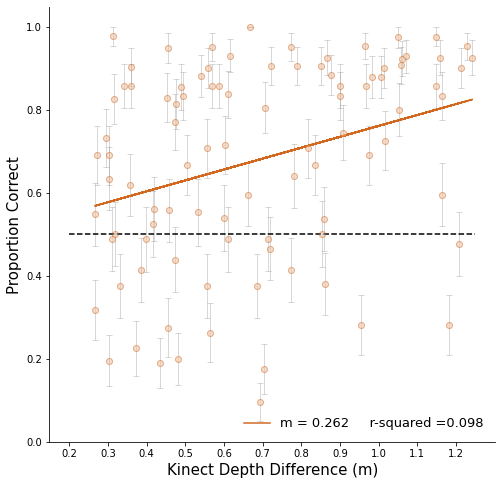

In [63]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_250 = np.array(final_y_250).reshape(-1,1)
y_250 = final_z_250
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(X_250, y_250, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(ste_250));

plt.plot(X_250, y_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(X_250,y_predicted_250,color='chocolate', label = 'm = ' + str(round(reg_250.coef_[0], 3))
         + '     r-squared ='+ str(round(float(reg_250.score(X_250, y_250)), 3)))

plt.xlabel("Kinect Depth Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

plt.plot([0.2, 1.25], [0.5,0.5], '--', color='black')


legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)


plt.xticks(np.arange(0.2,1.3, 0.1))
plt.yticks(np.arange(0,1.2, 0.2))

#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

In [ ]:
stats.pearsonr(final_y_1000, final_z_1000)

m: [0.32081343]
b: 0.46798390938877055
R-squared:  0.14206437247334847


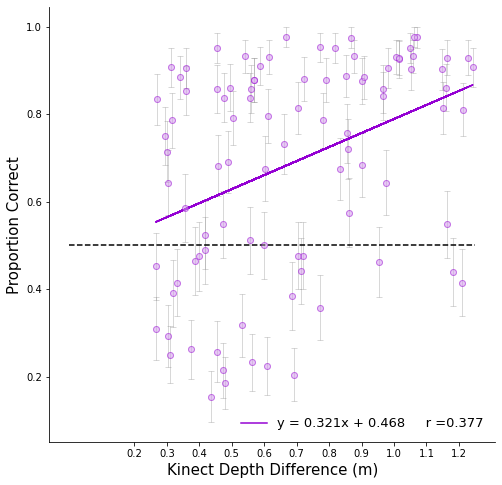

In [117]:
from sklearn.linear_model import LinearRegression

fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_1000 = np.array(final_y_1000).reshape(-1,1)
y_1000 = final_z_1000
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values
plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(ste_1000));

r = np.sqrt(round(float(reg_1000.score(X_1000, y_1000)), 3))
plt.plot(X_1000, y_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(X_1000,y_predicted_1000,color='darkviolet', label = 'y = ' + str(round(reg_1000.coef_[0], 3))
         + 'x + ' + str(round(reg_1000.intercept_, 3)) + '     r ='+ str(round(float(r), 3)))

plt.xlabel("Kinect Depth Difference (m)", fontsize = 15)
plt.ylabel("Proportion Correct", fontsize = 15)

plt.plot([0, 1.25], [0.5,0.5], '--', color='black')


legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)


plt.xticks(np.arange(0.2,1.3, 0.1))
# plt.yticks(np.arange(0.15,1.2, 0.2))

#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

### Prep RT data for plotting

In [125]:
# x = average depth of the targets 
final_x_250_RT = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_250_RT = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = average RT 
final_z_250_RT = [all_discrim_performance[key]['RT_250'][1] for key in all_discrim_performance]

final_250_RT_ste = [all_discrim_performance[key]['RT_250'][-1] for key in all_discrim_performance]

final_x_250_RT[0], final_y_250_RT[0], final_z_250_RT[0], final_250_RT_ste[0]

(1.4997500000000001,
 0.38650000000000007,
 1165.3658536585365,
 81.31398610758387)

In [126]:
# x = average depth of the targets 
final_x_1000_RT = [all_discrim_performance[key]['avg_depth'] for key in all_discrim_performance]
# y = depth difference of the targets
final_y_1000_RT = [all_discrim_performance[key]['depthdifference'] for key in all_discrim_performance]
# z = average RT 
final_z_1000_RT = [all_discrim_performance[key]['RT_1000'][1] for key in all_discrim_performance]

final_1000_RT_ste = [all_discrim_performance[key]['RT_1000'][-1] for key in all_discrim_performance]

final_x_1000_RT[0], final_y_1000_RT[0], final_z_1000_RT[0], final_1000_RT_ste[0]

(1.4997500000000001, 0.38650000000000007, 1020.0, 54.56020393710544)

m: [-63.69945308]
b: 1208.3714997971042
R-squared:  0.03883303869658028


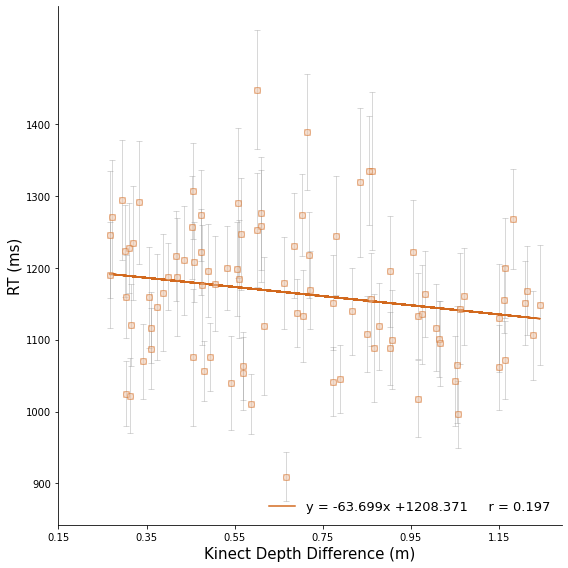

In [131]:
fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_250 = np.array(final_y_250).reshape(-1,1)
y_250 = final_z_250_RT
reg_250 = LinearRegression().fit(X_250, y_250)

#Generated Predictions
y_predicted_250 = reg_250.predict(X_250)
#Plot Our Actual and Predicted Values
plt.errorbar(X_250, y_250,elinewidth=1, ecolor='gray',fmt='or', mfc='white', mec='chocolate', capsize=3, alpha = 0.3, yerr = np.array(final_250_RT_ste));

r = np.sqrt(float(reg_250.score(X_250, y_250)))
plt.plot(X_250, y_250, 's', color='chocolate', alpha = 0.3);
plt.plot(X_250,y_predicted_250, '-',color='chocolate', label = 'y = ' + str(round(reg_250.coef_[0], 3))
        + 'x +' +str(round(float(reg_250.intercept_), 3)) + '     r = ' + str(round(r, 3)))

plt.xlabel("Kinect Depth Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)


legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.xticks(np.arange(0.15,1.2, 0.2))
plt.yticks(np.arange(900,1500, 100))


#get coefficients and y intercept
print("m: {0}".format(reg_250.coef_))
print("b: {0}".format(reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_250.score(X_250, y_250))

In [ ]:
stats.pearsonr(final_y_250, final_z_250_RT), stats.pearsonr(final_y_1000, final_z_1000_RT)

m: [-4.38199996]
b: 1069.8859039969839
R-squared:  0.00032770106311830194


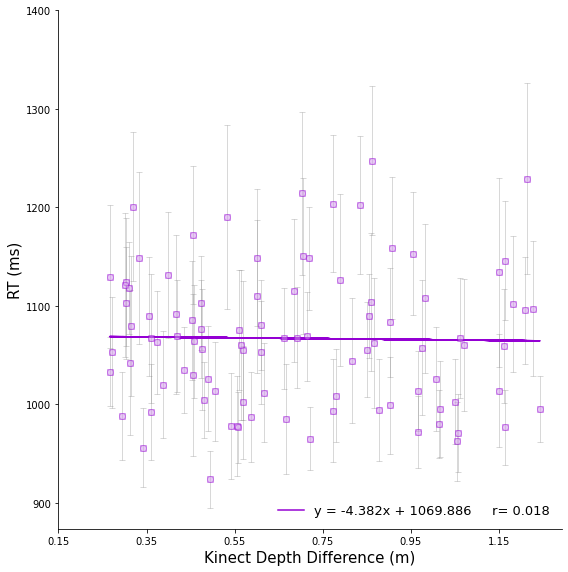

In [133]:

fig, ax = plt.subplots(figsize=[8,8])
right_side = ax.spines['right']
right_side.set_visible(False)
top = ax.spines['top']
top.set_visible(False)

#run regression
X_1000 = np.array(final_y_1000).reshape(-1,1)
y_1000 = final_z_1000_RT
reg_1000 = LinearRegression().fit(X_1000, y_1000)

#Generated Predictions
y_predicted_1000 = reg_1000.predict(X_1000)
#Plot Our Actual and Predicted Values

plt.errorbar(X_1000, y_1000, elinewidth=1, ecolor='gray', fmt='or', mfc='white', mec='darkviolet', capsize=3, alpha = 0.3, yerr = np.array(final_1000_RT_ste));

r = np.sqrt(float(reg_1000.score(X_1000, y_1000)))

plt.plot(X_1000, y_1000, 's', color='darkviolet', alpha = 0.3);
plt.plot(X_1000,y_predicted_1000, color='darkviolet', label = 'y = ' + str(round(reg_1000.coef_[0], 3))
         + 'x + ' + str(round(reg_1000.intercept_, 3))+ '     r= ' + str(round(r, 3)))

plt.xlabel("Kinect Depth Difference (m)", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)


legend = plt.legend(loc = 4, fontsize=13, labelspacing=1, frameon=False)

fig.tight_layout()

plt.xticks(np.arange(0.15,1.2, 0.2))
plt.yticks(np.arange(900,1500, 100))


#get coefficients and y intercept
print("m: {0}".format(reg_1000.coef_))
print("b: {0}".format(reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", reg_1000.score(X_1000, y_1000))

In [ ]:
# fig = plt.figure(figsize=[9,9])
# ax = plt.axes(projection='3d')

# # Data for three-dimensional scattered points
# zdata_RT = np.array(final_z_250_RT)
# xdata_RT = np.array(final_x_250_RT)
# ydata_RT = np.array(final_y_250_RT)
# ax.scatter3D(xdata_RT, ydata_RT, zdata_RT, c=zdata, cmap='Oranges');
# ax.set_xlabel('Average Depth of Trial Targets (m)')
# ax.set_ylabel('Depth Difference of Trial Targets (m)')
# ax.set_zlabel('Average RT (ms)');
# ax.set_title('Individulal Discrimination Avg RT: 250 ms', fontsize=16)

In [ ]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata_RT_1000 = np.array(final_z_1000_RT)
xdata_RT_1000 = np.array(final_x_1000_RT)
ydata_RT_1000 = np.array(final_y_1000_RT)
ax.scatter3D(xdata_RT_1000, ydata_RT_1000, zdata_RT_1000, c=zdata, cmap='Greens');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('Average RT (ms)');
ax.set_title('Individulal Discrimination Avg RT: 1000 ms', fontsize=16)

In [ ]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata_RT_1000 = np.array(final_z_1000_RT)
xdata_RT_1000 = np.array(final_x_1000_RT)
ydata_RT_1000 = np.array(final_y_1000_RT)
ax.scatter3D(xdata_RT, ydata_RT, zdata_RT, c=zdata, cmap='Oranges', label='250 ms');
ax.scatter3D(xdata_RT_1000, ydata_RT_1000, zdata_RT_1000, c=zdata, cmap='Greens', label='1000 ms');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('Average RT (ms)');
ax.set_title('Individulal Discrimination Avg RT', fontsize=16)
ax.legend()
plt.show();

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 8))

ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

num_elements = len(xpos)
zpos = [0] * num_elements
dx = np.ones(num_elements)
dy = np.ones(num_elements)

ax1.bar3d(final_x_250, final_y_250, zpos, dx, dy, final_z_250_RT, color='orange', shade=True)
ax1.set_title('250 ms', fontsize=15)
ax1.set_xlabel('Avg Depth of Trial Targets (m)', fontsize=11)
ax1.set_ylabel('Depth Diff of Trial Targets (m)', fontsize=11)
ax1.set_zlabel('RT (ms)', fontsize=11)

ax2.bar3d(final_x_1000, final_y_1000, zpos, dx, dy, final_z_1000_RT, color='green', shade=True)
ax2.set_title('1000 ms', fontsize=15)
ax2.set_xlabel('Avg Depth of Trial Targets (m)', fontsize=11)
ax2.set_ylabel('Depth Diff of Trial Targets (m)', fontsize=11)
ax2.set_zlabel('RT (ms)', fontsize=11)
fig.suptitle('Reaction Time', fontsize=15)

plt.show();

## Inverse Efficiency Score

It is calculated by dividing RT by 1 – the proportion of Errors (PE), or the proportion of correct responses (PC).

https://www.readcube.com/articles/10.5334/pb-51-1-5

In [ ]:
def inverse_efficiency_score(PC, RT):
    """
    Input:
        PC - proportion correct
        RT - reaction time 
    Output:
        ies - inverse efficiency score
    """
    
    ies = RT / PC
    
    return ies

In [ ]:
ies_250 = [inverse_efficiency_score(all_discrim_performance[key]['accuracy_250'][0], all_discrim_performance[key]['RT_250'][1]) for key in all_discrim_performance]

ies_1000 = [inverse_efficiency_score(all_discrim_performance[key]['accuracy_1000'][0], all_discrim_performance[key]['RT_1000'][1]) for key in all_discrim_performance]


In [ ]:
ies_250[0]

In [ ]:
fig = plt.figure(figsize=[9,9])
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
xdata_RT_1000 = np.array(final_x_1000_RT)
ydata_RT_1000 = np.array(final_y_1000_RT)
ax.scatter3D(xdata_RT, ydata_RT, np.array(ies_250), c=zdata, cmap='Oranges', label='250 ms');
ax.scatter3D(xdata_RT_1000, ydata_RT_1000, np.array(ies_1000), c=zdata, cmap='Greens', label='1000 ms');
ax.set_xlabel('Average Depth of Trial Targets (m)')
ax.set_ylabel('Depth Difference of Trial Targets (m)')
ax.set_zlabel('IES (ms)', fontsize = 13);
ax.set_title('Individulal Discrimination Inverse Efficiency Score', fontsize=16)
ax.legend(loc='lower left')
plt.show();

In [ ]:
plt.figure(figsize=[7,5])
plt.plot(ydata_RT, np.array(ies_250), 'o', color='orange', alpha = 0.9, label='250 ms')
plt.plot(ydata_RT_1000, np.array(ies_1000), 'o', color='green', alpha = 0.9, label='1000 ms')
plt.xlabel('Depth Difference of Trial Targets (m)')
plt.ylabel('IES (ms)')
plt.legend(loc='upper right')
plt.title('IES vs Depth Difference', fontsize=16)
plt.show();



In [ ]:
plt.figure(figsize=[7,5])
plt.plot(xdata_RT, np.array(ies_250), 'o', color='orange', alpha = 0.9, label='250 ms')
plt.plot(xdata_RT_1000, np.array(ies_1000), 'o', color='green', alpha = 0.9, label='1000 ms')
plt.xlabel('Average Depth of Targets (m)')
plt.ylabel('IES (ms)')
plt.legend(loc='upper right')
plt.title('IES vs Average Target Depth', fontsize=16)
plt.show();



In [ ]:
plt.figure(figsize = [10,7])
count_1000_higher = 0
for i in range(len(final_x_250)):
    avgdepth = final_x_250[i]
    pc250 = final_z_250[i]
    pc1000 = final_z_1000[i]
    if pc1000 > pc250:
        count_1000_higher += 1
    
    point1 = [avgdepth, pc250]
    point2 = [avgdepth, pc1000]
    
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(point1[0],point1[1],'-go') 
    plt.plot(point2[0],point2[1],'-ro') 
    if i == 0:
        plt.plot(point1[0],point1[1],'-go', label='250 ms') 
        plt.plot(point2[0],point2[1],'-ro', label='1000 ms') 
    else:
        plt.plot(point1[0],point1[1],'-go') 
        plt.plot(point2[0],point2[1],'-ro') 

    plt.plot(x_values, y_values, color='black')

plt.xlabel('Average Depth of Targets (m)', fontsize=15)
plt.ylabel('Proportion Correct', fontsize=15)
plt.legend(fontsize = 12)
plt.title('Proportion Correct vs. Average Depth of Targets', fontsize=15)
plt.show();
print(count_1000_higher)

In [ ]:
len(final_x_250)

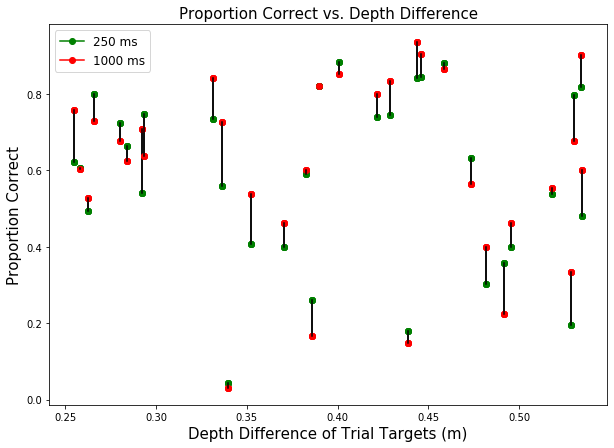

In [212]:
plt.figure(figsize = [10,7])
for i in range(len(final_x_250)):
    depthdiff = final_y_250[i]
    pc250 = final_z_250[i]
    pc1000 = final_z_1000[i]
    
    point1 = [depthdiff, pc250]
    point2 = [depthdiff, pc1000]
    
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(point1[0],point1[1],'-go') 
    plt.plot(point2[0],point2[1],'-ro') 
    if i == 0:
        plt.plot(point1[0],point1[1],'-go', label='250 ms') 
        plt.plot(point2[0],point2[1],'-ro', label='1000 ms') 
    else:
        plt.plot(point1[0],point1[1],'-go') 
        plt.plot(point2[0],point2[1],'-ro') 

    plt.plot(x_values, y_values, color='black')

plt.xlabel('Depth Difference of Trial Targets (m)', fontsize=15)
plt.ylabel('Proportion Correct', fontsize=15)
plt.legend(fontsize = 12)
plt.title('Proportion Correct vs. Depth Difference', fontsize=15)
plt.show();

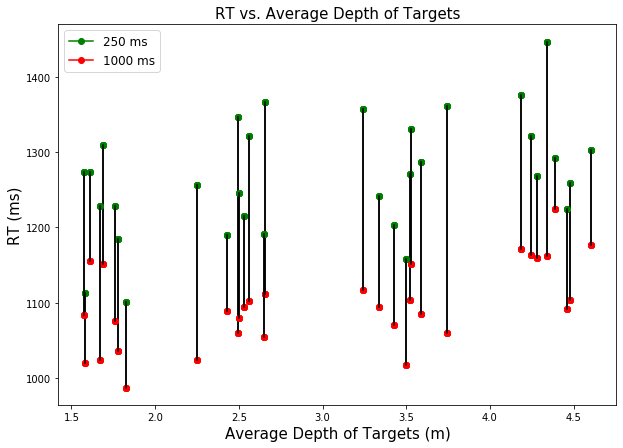

In [73]:
plt.figure(figsize = [10,7])
for i in range(len(final_x_250)):
    avgdepth = final_x_250[i]
    pc250 = final_z_250_RT[i]
    pc1000 = final_z_1000_RT[i]
    
    point1 = [avgdepth, pc250]
    point2 = [avgdepth, pc1000]
    
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(point1[0],point1[1],'-go') 
    plt.plot(point2[0],point2[1],'-ro') 
    if i == 0:
        plt.plot(point1[0],point1[1],'-go', label='250 ms') 
        plt.plot(point2[0],point2[1],'-ro', label='1000 ms') 
    else:
        plt.plot(point1[0],point1[1],'-go') 
        plt.plot(point2[0],point2[1],'-ro') 

    plt.plot(x_values, y_values, color='black')

plt.xlabel('Average Depth of Targets (m)', fontsize=15)
plt.ylabel('RT (ms)', fontsize=15)
plt.legend(fontsize = 12)
plt.title('RT vs. Average Depth of Targets', fontsize=15)
plt.show();

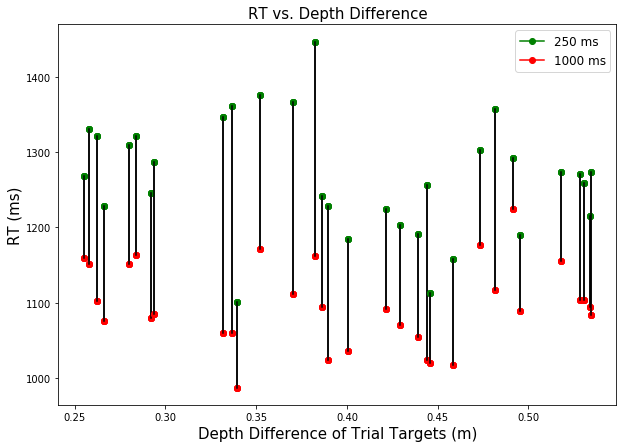

In [74]:
plt.figure(figsize = [10,7])
for i in range(len(final_x_250)):
    depthdiff = final_y_250[i]
    pc250 = final_z_250_RT[i]
    pc1000 = final_z_1000_RT[i]
    
    point1 = [depthdiff, pc250]
    point2 = [depthdiff, pc1000]
    
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(point1[0],point1[1],'-go') 
    plt.plot(point2[0],point2[1],'-ro') 
    if i == 0:
        plt.plot(point1[0],point1[1],'-go', label='250 ms') 
        plt.plot(point2[0],point2[1],'-ro', label='1000 ms') 
    else:
        plt.plot(point1[0],point1[1],'-go') 
        plt.plot(point2[0],point2[1],'-ro') 

    plt.plot(x_values, y_values, color='black')

plt.xlabel('Depth Difference of Trial Targets (m)', fontsize=15)
plt.ylabel('RT (ms)', fontsize=15)
plt.legend(fontsize = 12)
plt.title('RT vs. Depth Difference', fontsize=15)
plt.show();

In [75]:
# all_discrim_performance['depth_discrimination_stimuli/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4/001175_2014-06-17_15-45-55_260595134347_rgbf000129-resize_4-target.png']


In [76]:
# stim_df[['subjID', 'stimulus_0', 'actual_depth_0', 'stimulus_1', 'actual_depth_1', 'depth_difference', 'discrim_choice']]

# Correlation with Verbal Report data 

- For each discrimination trial, get the average difference between the verbal report for those scenes 
- Correlate that with the proportion correct for that trial 
- Is there better accuracy for scenes that have a larget percevied depth difference (using the verbal report data)?

In [77]:
all_discrim_performance['depth_discrimination_stimuli/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3-target.png']


{'stimulus_1': 'depth_discrimination_stimuli/000109_2014-05-14_23-41-52_260595134347_rgbf000035-resize_9/000109_2014-05-14_23-41-52_260595134347_rgbf000035-resize_9-target.png',
 'accuracy_250': (0.5376344086021505, 50, 93, 1),
 'accuracy_1000': (0.5531914893617021, 52, 94, 0),
 'avg_depth': 1.6135000000000002,
 'depthdifference': 0.518,
 'RT_250': (array([ 930.,  962.,  901., 1191., 1017., 1460.,  764.,  837., 2994.,
         1533.,  889.,  889., 1498., 1564., 1114., 1694., 1237., 1568.,
          654., 1146., 1159.,  651., 1045.,  825., 2908., 1023.,  817.,
         1156.,  994.,  968.,  961., 1003.,  841.,  689., 2638., 2444.,
         1446., 1187.,  955., 1408., 1916., 1198.,  991., 1180.,  859.,
         1602., 1637., 1010., 1165.,  917., 1174., 1181., 1116.,  857.,
         2417., 1288.,  767., 1017.,  890.,  544., 1577., 1588.,  862.,
         1768.,  945., 1441., 1039., 1045., 1622., 2516.,  961., 2214.,
          963.,  954.,  829.,  882.,  920., 1088., 3328., 1012.,  794.,
  

In [89]:
# TAC_raw_individual_trial_data_path = '/Users/prachi/Documents/depth_duration/depth_duration_analysis/TAC_npy_files/TAC_raw_individual_trial_data/'

TAC_raw_individual_trial_data_path  = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_npy_files/TAC_raw_individual_trial_data/'

# x data
with open(TAC_raw_individual_trial_data_path + 'X_250.npy' , 'rb') as f:
    TAC_X_250 = np.load(f, allow_pickle=True)

with open(TAC_raw_individual_trial_data_path + 'X_500.npy' , 'rb') as f:
    TAC_X_500 = np.load(f, allow_pickle=True)
    
with open(TAC_raw_individual_trial_data_path + 'X_750.npy' , 'rb') as f:
    TAC_X_750 = np.load(f, allow_pickle=True)

with open(TAC_raw_individual_trial_data_path + 'X_1000.npy' , 'rb') as f:
    TAC_X_1000 = np.load(f, allow_pickle=True)
# y data 
with open(TAC_raw_individual_trial_data_path + 'final_y_250.npy' , 'rb') as f:
    TAC_final_y_250 = np.load(f, allow_pickle=True)
    
with open(TAC_raw_individual_trial_data_path + 'final_y_500.npy' , 'rb') as f:
    TAC_final_y_500 = np.load(f, allow_pickle=True)
    
with open(TAC_raw_individual_trial_data_path + 'final_y_750.npy' , 'rb') as f:
    TAC_final_y_750 = np.load(f, allow_pickle=True)
    
with open(TAC_raw_individual_trial_data_path + 'final_y_1000.npy' , 'rb') as f:
    TAC_final_y_1000= np.load(f, allow_pickle=True)
    
with open(TAC_raw_individual_trial_data_path + 'final_stim_250.npy', 'rb') as f:
    TAC_final_stim_250 = np.load(f, allow_pickle=True)
    
with open(TAC_raw_individual_trial_data_path + 'final_stim_500.npy', 'rb') as f:
    TAC_final_stim_500 = np.load(f, allow_pickle=True)
    
with open(TAC_raw_individual_trial_data_path + 'final_stim_750.npy', 'rb') as f:
    TAC_final_stim_750 = np.load(f, allow_pickle=True)
    
with open(TAC_raw_individual_trial_data_path + 'final_stim_1000.npy', 'rb') as f:
    TAC_final_stim_1000 = np.load(f, allow_pickle=True)
    
# std data
with open(TAC_raw_individual_trial_data_path + 'std_250.npy' , 'rb') as f:
    TAC_std_250 = np.load(f, allow_pickle=True)

with open(TAC_raw_individual_trial_data_path + 'std_500.npy' , 'rb') as f:
    TAC_std_500 = np.load(f, allow_pickle=True)
    
with open(TAC_raw_individual_trial_data_path + 'std_750.npy' , 'rb') as f:
    TAC_std_750 = np.load(f, allow_pickle=True)

with open(TAC_raw_individual_trial_data_path + 'std_1000.npy' , 'rb') as f:
    TAC_std_1000 = np.load(f, allow_pickle=True)

In [90]:
len(TAC_final_y_250)

192

In [91]:
accuracy_250 = [] # list of the proportion correct for each trial
avg_verbal_estim_diff_250 = [] # corresponding list of absolute average difference between the verbal reports for the discrimination trial images 

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(TAC_final_stim_250 == depth_dur_path0)[0][0]
    avg_estim_stim0 = TAC_final_y_250[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(TAC_final_stim_250 == depth_dur_path1)[0][0]
    avg_estim_stim1 = TAC_final_y_250[idx1]
    
    avg_estim_diff = abs(avg_estim_stim0 - avg_estim_stim1)
    avg_verbal_estim_diff_250.append(avg_estim_diff)
    
    trial_accuracy = all_discrim_performance[key]['accuracy_250'][0]
    accuracy_250.append(trial_accuracy)
    

In [92]:
print('250 ms: Correlation between discrimination accuracy and average verbal estimate difference')
stats.pearsonr(accuracy_250, avg_verbal_estim_diff_250)

250 ms: Correlation between discrimination accuracy and average verbal estimate difference


(0.14741167941560976, 0.24506734086344828)

In [93]:
accuracy_1000 = [] # list of the proportion correct for each trial
avg_verbal_estim_diff_1000 = [] # corresponding list of absolute average difference between the verbal reports for the discrimination trial images 

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(TAC_final_stim_1000 == depth_dur_path0)[0][0]
    avg_estim_stim0 = TAC_final_y_1000[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(TAC_final_stim_1000 == depth_dur_path1)[0][0]
    avg_estim_stim1 = TAC_final_y_1000[idx1]
    
    avg_estim_diff = abs(avg_estim_stim0 - avg_estim_stim1)
    avg_verbal_estim_diff_1000.append(avg_estim_diff)
    
    trial_accuracy = all_discrim_performance[key]['accuracy_1000'][0]
    accuracy_1000.append(trial_accuracy)
    if trial_accuracy < 0.1:
        print(key)
        print(avg_estim_stim0, avg_estim_stim1)
    

depth_discrimination_stimuli/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0-target.png
1.332272340425532 2.14677
depth_discrimination_stimuli/001016_2014-06-09_16-16-10_260595134347_rgbf000112-resize_5/001016_2014-06-09_16-16-10_260595134347_rgbf000112-resize_5-target.png
2.14677 1.332272340425532


In [94]:
all_discrim_performance['depth_discrimination_stimuli/001016_2014-06-09_16-16-10_260595134347_rgbf000112-resize_5/001016_2014-06-09_16-16-10_260595134347_rgbf000112-resize_5-target.png']

{'stimulus_1': 'depth_discrimination_stimuli/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0/002199_2014-06-28_18-33-56_260595134347_rgbf000074-resize_0-target.png',
 'accuracy_250': (0.042105263157894736, 4, 95, 0),
 'accuracy_1000': (0.031578947368421054, 3, 95, 0),
 'avg_depth': 1.82625,
 'depthdifference': 0.3394999999999999,
 'RT_250': (array([ 821.,  805., 1104., 1219., 1128.,  934.,  909., 1954., 1406.,
         1159.,  832.,  851.,  747.,  854.,  952., 1234.,  941., 1033.,
          867.,  986., 1886.,  954., 1129.,  948.,  829., 1283., 1145.,
          885.,  998.,  844.,  943., 1002.,  967.,  908.,  822.,  773.,
          996., 1065.,  968., 1192., 1225.,  966.,  734., 1089., 1036.,
         1335.,  982.,  798.,  807., 1025.,  871.,  836.,  866., 1526.,
          907.,  919., 1098.,  778.,  900.,  774., 1713., 1056., 1112.,
         2034.,  974.,  880., 1058., 1000.,  685., 1093., 2204.,  786.,
         3557., 1798.,  804.,  911., 1067., 1208.,  896.,  969.,  810.

In [95]:
print('1000 ms: Correlation between depth differences and average verbal estimate difference')
stats.pearsonr(accuracy_1000, avg_verbal_estim_diff_1000)

1000 ms: Correlation between depth differences and average verbal estimate difference


(0.21111974122885838, 0.09401209934270034)

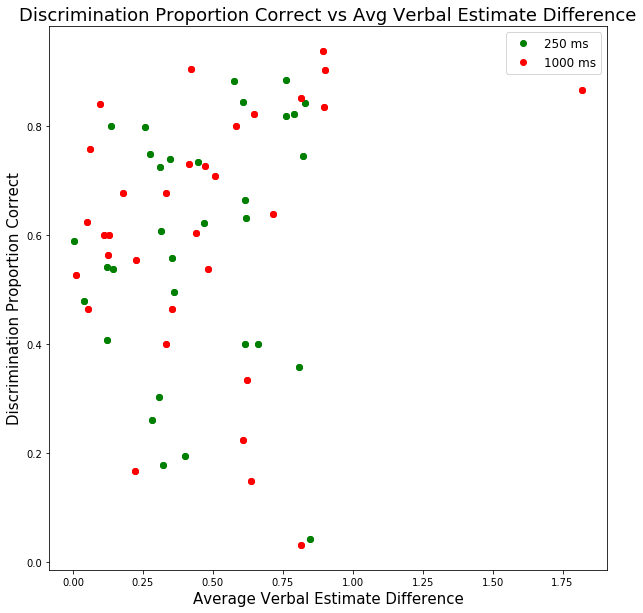

In [96]:
plt.figure(figsize=[10,10])
plt.plot(np.array(avg_verbal_estim_diff_250), np.array(accuracy_250), 'go', label='250 ms')
plt.plot(np.array(avg_verbal_estim_diff_1000), np.array(accuracy_1000), 'ro', label='1000 ms')
plt.xlabel('Average Verbal Estimate Difference', fontsize=15)
plt.ylabel('Discrimination Proportion Correct', fontsize = 15)
plt.legend(fontsize = 12)
plt.title('Discrimination Proportion Correct vs Avg Verbal Estimate Difference', fontsize = 18)
plt.show();

# NEW: Code depth discrimination correctness by the verbal judgement data 

Create new 'ground truth' answer based on verbal judgement data

Task: Respond which image's target was closer to you

In [97]:
VE_answerkey_250 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(TAC_final_stim_250 == depth_dur_path0)[0][0]
    avg_estim_stim0 = TAC_final_y_250[idx0]
    std0 = TAC_std_250[idx0]
    
    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(TAC_final_stim_250 == depth_dur_path1)[0][0]
    avg_estim_stim1 = TAC_final_y_250[idx1]
    std1 = TAC_std_250[idx1]

    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    VE_answerkey_250[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1}
    

In [98]:
len(VE_answerkey_250), VE_answerkey_250['depth_discrimination_stimuli/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1-target.png']


(64,
 {'stimulus_1': '001164_2014-06-17_15-35-46_260595134347_rgbf000085-resize_3-target.png',
  'stimulus_0_avg_estim': 2.103344680851064,
  'stimulus_1_avg_estim': 2.225165,
  'answer': '002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1-target.png',
  'std0': 1.0871992047395496,
  'std1': 0.9802619260437813})

In [99]:
VE_answerkey_1000 = {} # corresponding answer key for discrimination trials  

for key in all_discrim_performance.keys():
    targetimg0 = key.split('/')[-1]
    folder0 = targetimg0[:-11]
    depth_dur_path0 = 'depth_duration_stimuli/' + folder0 + '/' + targetimg0
    idx0 = np.where(TAC_final_stim_1000 == depth_dur_path0)[0][0]
    avg_estim_stim0 = TAC_final_y_1000[idx0]
    std0 = TAC_std_1000[idx0]

    targetimg1 = all_discrim_performance[key]['stimulus_1'].split('/')[-1]
    folder1 = targetimg1[:-11]
    depth_dur_path1 = 'depth_duration_stimuli/' + folder1 + '/' + targetimg1
    idx1= np.where(TAC_final_stim_1000 == depth_dur_path1)[0][0]
    avg_estim_stim1 = TAC_final_y_1000[idx1]
    std1 = TAC_std_1000[idx1]
    
    if avg_estim_stim0 < avg_estim_stim1:
        # Which target is CLOSER to you?
        answer = targetimg0
    if avg_estim_stim0 == avg_estim_stim1:
        print(targetimg0, targetimg1)
    if avg_estim_stim0 > avg_estim_stim1:
        answer = targetimg1

    VE_answerkey_1000[key] = {'stimulus_1': targetimg1,
                             'stimulus_0_avg_estim': avg_estim_stim0,
                             'stimulus_1_avg_estim': avg_estim_stim1,
                             'answer': answer,
                             'std0': std0,
                             'std1': std1}
    

In [100]:
len(VE_answerkey_1000), VE_answerkey_1000['depth_discrimination_stimuli/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1/002118_2014-06-25_20-32-08_260595134347_rgbf000078-resize_1-target.png']


(64,
 {'stimulus_1': '001164_2014-06-17_15-35-46_260595134347_rgbf000085-resize_3-target.png',
  'stimulus_0_avg_estim': 2.2761083333333336,
  'stimulus_1_avg_estim': 1.76819,
  'answer': '001164_2014-06-17_15-35-46_260595134347_rgbf000085-resize_3-target.png',
  'std0': 1.3918335208336923,
  'std1': 1.2276693732053363})

In [101]:
def VE_accuracy(stim0, df, answerkey):
    '''
    Accuracy based on the verbal judgement data 
    '''
    
    """
    args:
        df  
    returns:
        proportion of correct responses, count of correct responses, count of total trials  
    """
    count_correct = 0
    count_incorrect = 0
    count_total = 0
    count_missed = 0
    
    VE_correct_answer = answerkey[stim0]['answer']
    for idx, row in df.iterrows(): 
        choice = row["discrim_choice"]
        count_total += 1
        if choice == 0.0:
            image_choice = row["stimulus_0"]
                
        if choice == 1.0:
            image_choice = row["stimulus_1"]
                
        if choice == 2.0:
            count_missed += 1
            
        if choice == 3.0:
            count_missed += 1
        
        try:
            if image_choice.split('/')[-1] == VE_correct_answer:
                count_correct += 1
        except:
            pass
        
    
    return count_correct/count_total, count_correct, count_total, count_missed

    
def main_VE_accuracy(df, answerkey_250, answerkey_1000):
    all_stim0 = df.stimulus_0.unique()
    
    stimuli_stats = {}
    for stim0 in all_stim0:
        # dataframe for stimulus 0
        stim0_df = df.loc[df['stimulus_0'] == stim0]
        # name of stimulus 1
        other_stim = stim0_df.stimulus_1.unique()[0]
        # dataframe where stimulus 0 is presented SECOND (same trial)
        stim1_df = df.loc[df['stimulus_1'] == stim0]
        
        # df for a specific discrimination trial (collapsed on stim presentation order)
        stim_df = pd.concat([stim0_df, stim1_df], ignore_index=True)
        stim_250_df = stim_df[stim_df['duration'] == 250.0]
        stim_1000_df = stim_df[stim_df['duration'] == 1000.0] 
        
#         stim_depthdiff = stim_df['depth_difference'][0]
        
        stim0_depth = stim_df['actual_depth_0'][0]
        stim1_depth = stim_df['actual_depth_1'][0]
        stim_depthbin = np.mean(np.array([stim0_depth,stim1_depth]))
        
        stim_acc_250 = VE_accuracy(stim0, stim_250_df, answerkey_250)
        stim_acc_1000 = VE_accuracy(stim0, stim_1000_df, answerkey_1000)
        
        stim_RT_250 = get_RT(stim_250_df)
        stim_RT_1000 = get_RT(stim_1000_df)
        
        # difference between verbal judgements divided by joint variance 
        # abs(VE1-VE2)/sqrt(stda^2 + std2^2)
        std0_250 = answerkey_250[stim0]['std0']
        std1_250 = answerkey_250[stim0]['std1']
        joint_variance_250 = np.sqrt(std0_250**2 + std1_250**2)
        JV_regressor_250 = abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim'])/joint_variance_250
        
        std0_1000 = answerkey_1000[stim0]['std0']
        std1_1000 = answerkey_1000[stim0]['std1']
        joint_variance_1000 = np.sqrt(std0_1000**2 + std1_1000**2)
        JV_regressor_1000 = abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim'])/joint_variance_1000
        
        stimuli_stats[stim0] = {'stimulus_1': other_stim,
                                'accuracy_250': stim_acc_250,
                                'accuracy_1000': stim_acc_1000,
                                'avg_depth': stim_depthbin,
                                'VE_depthdifference_250': abs(answerkey_250[stim0]['stimulus_0_avg_estim'] - answerkey_250[stim0]['stimulus_1_avg_estim']), 
                                'VE_depthdifference_1000': abs(answerkey_1000[stim0]['stimulus_0_avg_estim'] - answerkey_1000[stim0]['stimulus_1_avg_estim']),
                                'RT_250': stim_RT_250,
                                'RT_1000': stim_RT_1000,
                                'JV_regressor_250': JV_regressor_250,
                                'JV_regressor_1000': JV_regressor_1000}
        
    
    return stimuli_stats
    

In [102]:
all_VE_discrim_performance = main_VE_accuracy(final_discrim, VE_answerkey_250, VE_answerkey_1000) 

In [103]:
all_VE_discrim_performance['depth_discrimination_stimuli/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3-target.png']



{'stimulus_1': 'depth_discrimination_stimuli/000109_2014-05-14_23-41-52_260595134347_rgbf000035-resize_9/000109_2014-05-14_23-41-52_260595134347_rgbf000035-resize_9-target.png',
 'accuracy_250': (0.5425531914893617, 51, 94, 2),
 'accuracy_1000': (0.5851063829787234, 55, 94, 3),
 'avg_depth': 1.6135000000000002,
 'VE_depthdifference_250': 0.1437466666666667,
 'VE_depthdifference_1000': 0.22626497687326563,
 'RT_250': (array([ 930.,  962.,  901., 1191., 1017., 1460.,  764.,  837., 2994.,
         1533.,  889.,  889., 1498., 1564., 1114., 1694., 1237., 1568.,
          654., 1146., 1159.,  651., 1045.,  825., 2908., 1023.,  817.,
         1156.,  994.,  968.,  961., 1003.,  841.,  689., 2638., 2444.,
         1446., 1187.,  955., 1408., 1916., 1198.,  991., 1180.,  859.,
         1602., 1637., 1010., 1165.,  917., 1174., 1181., 1116.,  857.,
         2417., 1288.,  767., 1017.,  890.,  544., 1577., 1588.,  862.,
         1768.,  945., 1441., 1039., 1045., 1622., 2516.,  961., 2214.,
     

In [104]:
VE_estim_diff_250 = [all_VE_discrim_performance[elem]['VE_depthdifference_250'] for elem in all_VE_discrim_performance]
VE_estim_diff_1000 = [all_VE_discrim_performance[elem]['VE_depthdifference_1000'] for elem in all_VE_discrim_performance]

VE_accuracy_250 = [all_VE_discrim_performance[elem]['accuracy_250'][0] for elem in all_VE_discrim_performance]
VE_accuracy_1000 = [all_VE_discrim_performance[elem]['accuracy_1000'][0] for elem in all_VE_discrim_performance]

avg_RT_250 = [all_VE_discrim_performance[elem]['RT_250'][1] for elem in all_VE_discrim_performance]
avg_RT_1000 = [all_VE_discrim_performance[elem]['RT_1000'][1] for elem in all_VE_discrim_performance]

JV_250 = [all_VE_discrim_performance[elem]['JV_regressor_250'] for elem in all_VE_discrim_performance]
JV_1000 = [all_VE_discrim_performance[elem]['JV_regressor_1000'] for elem in all_VE_discrim_performance]

#### Overall Accuracy: Coded by VE

In [139]:
np.mean(VE_accuracy_250), np.mean(VE_accuracy_1000)

(0.6905368766669375, 0.643007541469647)

In [106]:
print('250 ms: Correlation between VE discrimination accuracy and average verbal estimate difference')
stats.pearsonr(VE_accuracy_250, VE_estim_diff_250)

250 ms: Correlation between VE discrimination accuracy and average verbal estimate difference


(0.5652228823452243, 1.1388307677219579e-06)

In [107]:
print('1000 ms: Correlation between VE discrimination accuracy and average verbal estimate difference')
stats.pearsonr(VE_accuracy_1000, VE_estim_diff_1000)

1000 ms: Correlation between VE discrimination accuracy and average verbal estimate difference


(0.49830746903415124, 2.7867267325808916e-05)

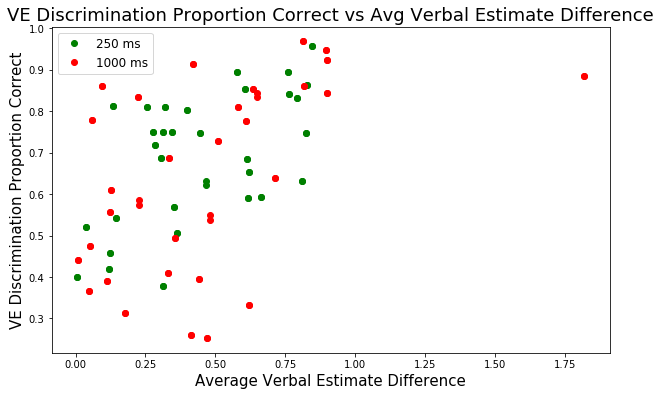

In [108]:
plt.figure(figsize=[10,6])
plt.plot(np.array(VE_estim_diff_250), np.array(VE_accuracy_250), 'go', label='250 ms')
plt.plot(np.array(VE_estim_diff_1000), np.array(VE_accuracy_1000), 'ro', label='1000 ms')
plt.xlabel('Average Verbal Estimate Difference', fontsize=15)
plt.ylabel('VE Discrimination Proportion Correct', fontsize = 15)
plt.legend(fontsize = 12)
plt.title('VE Discrimination Proportion Correct vs Avg Verbal Estimate Difference', fontsize = 18)
plt.show();

m: [0.34760051]
b: 0.5350003982856293
R-squared:  0.3194769067266434


Text(0.5, 1.0, '250 ms: Accuracy')

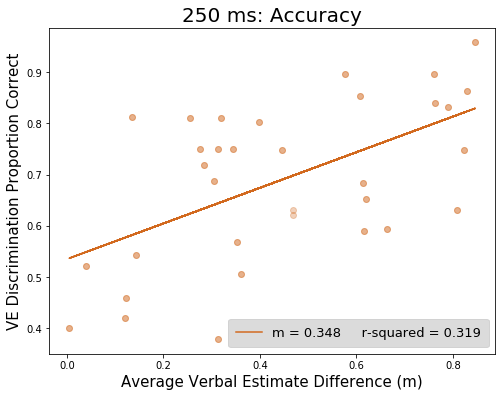

In [109]:
#run regression
plt.figure(figsize=[8,6])
VE_X_250 = np.array(VE_estim_diff_250).reshape(-1,1)
VE_PC_250 = VE_accuracy_250
VE_PC_reg_250 = LinearRegression().fit(VE_X_250, VE_PC_250)

#Generated Predictions
PC_predicted_250 = VE_PC_reg_250.predict(VE_X_250)
#Plot Our Actual and Predicted Values
plt.plot(VE_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(VE_X_250, PC_predicted_250,color='chocolate', label = 'm = ' + str(round(VE_PC_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(VE_PC_reg_250.score(VE_X_250, VE_PC_250)), 3)))
plt.xlabel("Average Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("VE Discrimination Proportion Correct", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_250.coef_))
print("b: {0}".format(VE_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_250.score(VE_X_250, VE_PC_250))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("250 ms: Accuracy", fontsize = 20)


m: [0.30590189]
b: 0.5000024230523517
R-squared:  0.24831033369522149


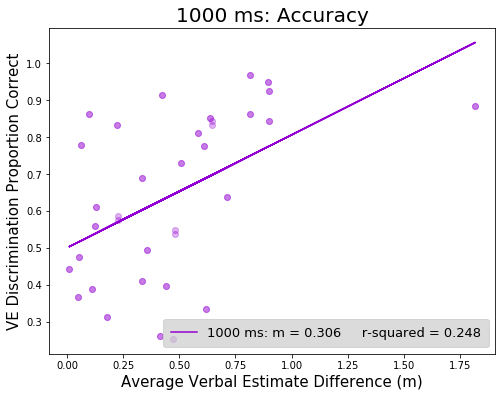

In [110]:
plt.figure(figsize=[8,6])

VE_X_1000 = np.array(VE_estim_diff_1000).reshape(-1,1)
VE_PC_1000 = VE_accuracy_1000
VE_PC_reg_1000 = LinearRegression().fit(VE_X_1000, VE_PC_1000)

#Generated Predictions
PC_predicted_1000 = VE_PC_reg_1000.predict(VE_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(VE_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(VE_X_1000, PC_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(VE_PC_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000)), 3)))

legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

#get coefficients and y intercept
print("m: {0}".format(VE_PC_reg_1000.coef_))
print("b: {0}".format(VE_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_PC_reg_1000.score(VE_X_1000, VE_PC_1000))

plt.xlabel("Average Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("VE Discrimination Proportion Correct", fontsize = 15)


plt.title("1000 ms: Accuracy", fontsize = 20)

plt.show();

## REACTION TIME

In [111]:
print('250 ms: Correlation between average discrimination RT and average verbal estimate difference')
stats.pearsonr(avg_RT_250, VE_estim_diff_250)

250 ms: Correlation between average discrimination RT and average verbal estimate difference


(-0.4573727601850303, 0.0001449531697090247)

In [112]:
print('1000 ms: Correlation between average discrimination RT and average verbal estimate difference')
stats.pearsonr(avg_RT_1000, VE_estim_diff_1000)

1000 ms: Correlation between average discrimination RT and average verbal estimate difference


(-0.5010015862170688, 2.4813546425072763e-05)

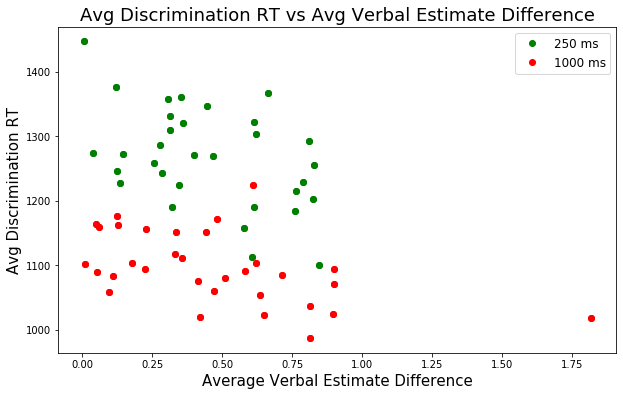

In [113]:
plt.figure(figsize=[10,6])
plt.plot(np.array(VE_estim_diff_250), np.array(avg_RT_250), 'go', label='250 ms')
plt.plot(np.array(VE_estim_diff_1000), np.array(avg_RT_1000), 'ro', label='1000 ms')
plt.xlabel('Average Verbal Estimate Difference', fontsize=15)
plt.ylabel('Avg Discrimination RT', fontsize = 15)
plt.legend(fontsize = 12)
plt.title('Avg Discrimination RT vs Avg Verbal Estimate Difference', fontsize = 18)
plt.show();

m: [-138.70546212]
b: 1329.1017989597779
R-squared:  0.2091898417592739


Text(0.5, 1.0, '250 ms: RT')

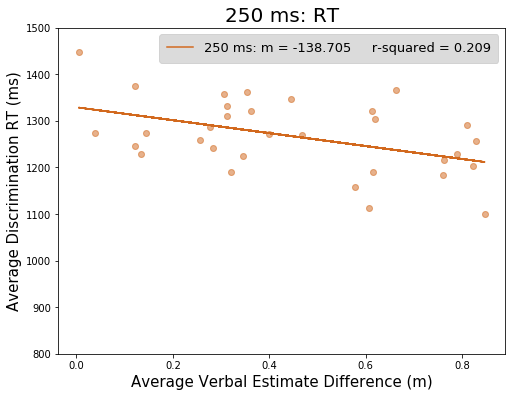

In [114]:
#run regression
plt.figure(figsize=[8,6])
VE_X_250 = np.array(VE_estim_diff_250).reshape(-1,1)
VE_RT_250 = avg_RT_250
VE_reg_250 = LinearRegression().fit(VE_X_250, VE_RT_250)

#Generated Predictions
RT_predicted_250 = VE_reg_250.predict(VE_X_250)
#Plot Our Actual and Predicted Values
plt.plot(VE_X_250, VE_RT_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(VE_X_250, RT_predicted_250,color='chocolate', label = '250 ms: m = ' + str(round(VE_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(VE_reg_250.score(VE_X_250, VE_RT_250)), 3)))
plt.xlabel("Average Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Average Discrimination RT (ms)", fontsize = 15)
plt.yticks(np.arange(800, 1600, 100))
legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

#get coefficients and y intercept
print("m: {0}".format(VE_reg_250.coef_))
print("b: {0}".format(VE_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_reg_250.score(VE_X_250, VE_RT_250))

plt.title("250 ms: RT", fontsize = 20)



m: [-75.02727758]
b: 1132.0077285593015
R-squared:  0.2510025893920186


Text(0.5, 1.0, '1000 ms: RT')

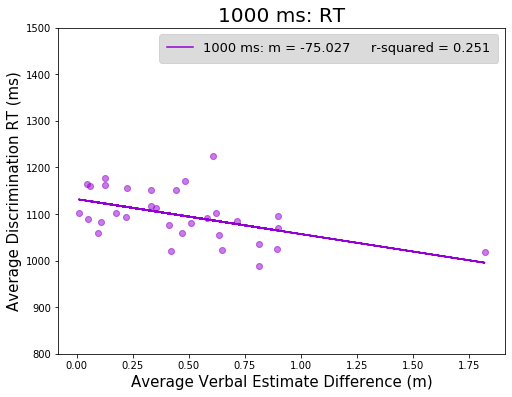

In [115]:
plt.figure(figsize=[8,6])

VE_X_1000 = np.array(VE_estim_diff_1000).reshape(-1,1)
VE_RT_1000 = avg_RT_1000
VE_reg_1000 = LinearRegression().fit(VE_X_1000, VE_RT_1000)

#Generated Predictions
RT_predicted_1000 = VE_reg_1000.predict(VE_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(VE_X_1000, VE_RT_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(VE_X_1000, RT_predicted_1000,color='darkviolet', label = '1000 ms: m = ' + str(round(VE_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(VE_reg_1000.score(VE_X_1000, VE_RT_1000)), 3)))
plt.xlabel("Average Verbal Estimate Difference (m)", fontsize = 15)
plt.ylabel("Average Discrimination RT (ms)", fontsize = 15)
plt.yticks(np.arange(800, 1600, 100))

legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

#get coefficients and y intercept
print("m: {0}".format(VE_reg_1000.coef_))
print("b: {0}".format(VE_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", VE_reg_1000.score(VE_X_1000, VE_RT_1000))

plt.title("1000 ms: RT", fontsize = 20)


In [116]:
# #run regression
# plt.figure(figsize=[8,6])
# VE_X_1000 = np.array(VE_estim_diff_1000).reshape(-1,1)
# VE_RT_1000 = avg_RT_1000
# VE_reg_1000 = LinearRegression().fit(VE_X_1000, VE_RT_1000)

# #Generated Predictions
# RT_predicted_1000 = VE_reg_1000.predict(VE_X_1000)
# #Plot Our Actual and Predicted Values
# plt.plot(VE_X_1000, VE_RT_1000, 'o', color='black', alpha = 0.7);
# plt.plot(VE_X_1000, RT_predicted_1000,color='red', label = 'm = ' + str(round(VE_reg_1000.coef_[0], 3))
#          + '     r-squared = ' + str(round(float(VE_reg_1000.score(VE_X_1000, VE_RT_1000)), 3)))
# plt.title("1000 ms", fontsize = 20)
# plt.xlabel("Avg Verbal Estimate Difference (m)", fontsize = 15)
# plt.ylabel("Avg Discrimination RT (m)", fontsize = 15)

# legend = plt.legend(loc = 0, fontsize = 13, borderpad = 0.6, labelspacing = 1)
# legend.get_frame().set_facecolor('lightgray')

# #get coefficients and y intercept
# print("m: {0}".format(VE_reg_1000.coef_))
# print("b: {0}".format(VE_reg_1000.intercept_))

# #Returns the coefficient of determination R^2 of the prediction.
# print("R-squared: ", VE_reg_1000.score(VE_X_1000, VE_RT_1000))

# UPDATED REGRESSOR: Difference between verbal judgements divided by joint variance 

In [117]:
print('250 ms: Correlation between VE discrimination accuracy and difference between verbal judgements divided by joint variance ')
stats.pearsonr(VE_accuracy_250, JV_250)

250 ms: Correlation between VE discrimination accuracy and difference between verbal judgements divided by joint variance 


(0.4175104174112364, 0.0005981448029273037)

In [118]:
print('1000 ms: Correlation between VE discrimination accuracy and difference between verbal judgements divided by joint variance ')
stats.pearsonr(VE_accuracy_1000, JV_1000)

1000 ms: Correlation between VE discrimination accuracy and difference between verbal judgements divided by joint variance 


(0.575712533661539, 6.460493273441671e-07)

m: [0.52613751]
b: 0.592541710250361
R-squared:  0.1743149486469049


Text(0.5, 1.0, '250 ms')

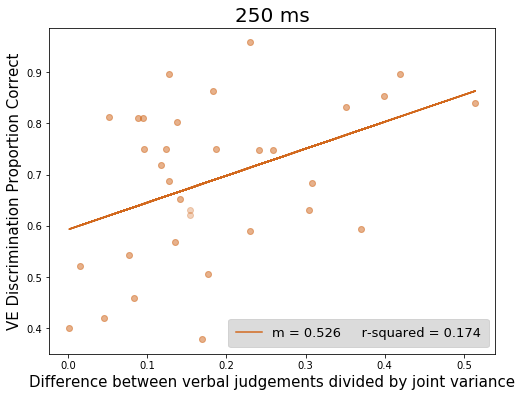

In [119]:
#run regression
plt.figure(figsize=[8,6])
JV_X_250 = np.array(JV_250).reshape(-1,1)
VE_PC_250 = VE_accuracy_250
JV_PC_reg_250 = LinearRegression().fit(JV_X_250, VE_PC_250)

#Generated Predictions
JV_PC_predicted_250 = JV_PC_reg_250.predict(JV_X_250)
#Plot Our Actual and Predicted Values
plt.plot(JV_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(JV_X_250, JV_PC_predicted_250,color='chocolate', label = 'm = ' + str(round(JV_PC_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_250.score(JV_X_250, VE_PC_250)), 3)))
plt.xlabel("Difference between verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("VE Discrimination Proportion Correct", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_250.coef_))
print("b: {0}".format(JV_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_250.score(JV_X_250, VE_PC_250))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("250 ms", fontsize = 20)


m: [0.84758066]
b: 0.4701313633153942
R-squared:  0.33144492141498855


Text(0.5, 1.0, '1000 ms')

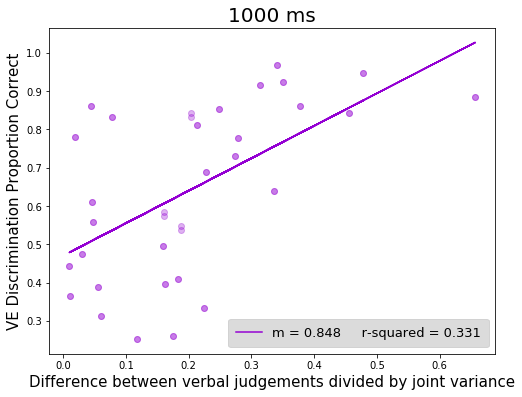

In [120]:
#run regression
plt.figure(figsize=[8,6])
JV_X_1000 = np.array(JV_1000).reshape(-1,1)
VE_PC_1000 = VE_accuracy_1000
JV_PC_reg_1000 = LinearRegression().fit(JV_X_1000, VE_PC_1000)

#Generated Predictions
JV_PC_predicted_1000 = JV_PC_reg_1000.predict(JV_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(JV_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(JV_X_1000, JV_PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(JV_PC_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000)), 3)))
plt.xlabel("Difference between verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("VE Discrimination Proportion Correct", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_1000.coef_))
print("b: {0}".format(JV_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("1000 ms", fontsize = 20)


In [121]:
print('250 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance ')
stats.pearsonr(avg_RT_250, JV_250)

250 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance 


(-0.3173306882657639, 0.010618187721972813)

In [122]:
print('1000 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance ')
stats.pearsonr(avg_RT_1000, JV_1000)

1000 ms: Correlation between average discrimination RT and difference between verbal judgements divided by joint variance 


(-0.49862500489144657, 2.749004766333309e-05)

m: [-197.19986881]
b: 1303.7662359539981
R-squared:  0.10069876571522329


Text(0.5, 1.0, '250 ms: RT')

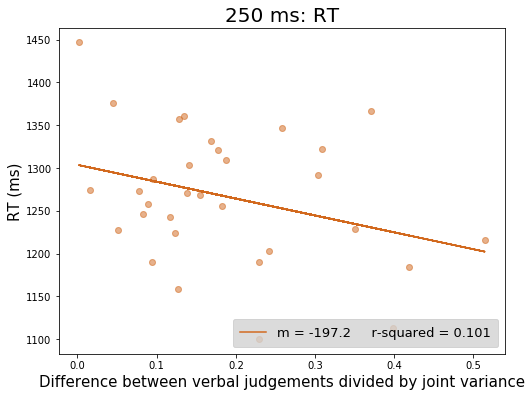

In [123]:
#run regression
plt.figure(figsize=[8,6])
JV_X_250 = np.array(JV_250).reshape(-1,1)
VE_PC_250 = avg_RT_250
JV_PC_reg_250 = LinearRegression().fit(JV_X_250, VE_PC_250)

#Generated Predictions
JV_PC_predicted_250 = JV_PC_reg_250.predict(JV_X_250)
#Plot Our Actual and Predicted Values
plt.plot(JV_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(JV_X_250, JV_PC_predicted_250,color='chocolate', label = 'm = ' + str(round(JV_PC_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_250.score(JV_X_250, VE_PC_250)), 3)))
plt.xlabel("Difference between verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_250.coef_))
print("b: {0}".format(JV_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_250.score(JV_X_250, VE_PC_250))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("250 ms: RT", fontsize = 20)

m: [-179.07902911]
b: 1133.4591861226932
R-squared:  0.2486268955029948


Text(0.5, 1.0, '1000 ms: RT')

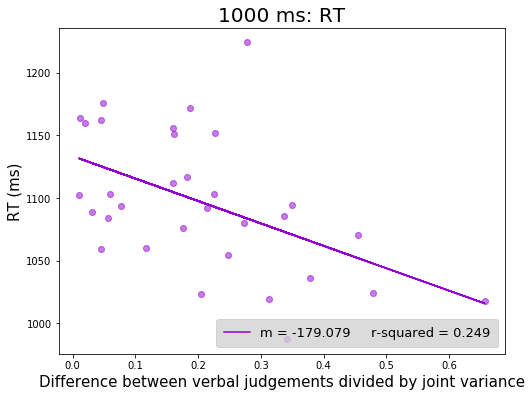

In [124]:
#run regression
plt.figure(figsize=[8,6])
JV_X_1000 = np.array(JV_1000).reshape(-1,1)
VE_PC_1000 = avg_RT_1000
JV_PC_reg_1000 = LinearRegression().fit(JV_X_1000, VE_PC_1000)

#Generated Predictions
JV_PC_predicted_1000 = JV_PC_reg_1000.predict(JV_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(JV_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(JV_X_1000, JV_PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(JV_PC_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000)), 3)))
plt.xlabel("Difference between verbal judgements divided by joint variance", fontsize = 15)
plt.ylabel("RT (ms)", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(JV_PC_reg_1000.coef_))
print("b: {0}".format(JV_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", JV_PC_reg_1000.score(JV_X_1000, VE_PC_1000))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("1000 ms: RT", fontsize = 20)

# Predictability of Discrimination RT based on summed VE trial RT 

In [129]:
datadir = '/Users/prachimahableshwarkar/Documents/GW/Depth_MTurk/depth_duration_analysis/TAC_data/'
durations = ['250', '500', '750', '1000']
TAC_rawPivot_RT = []

for i in range(len(durations)):  
    dur_data = pd.read_csv(datadir + 'rawPivot_' + durations[i] + '_RT.csv', index_col=None, header=0)
    TAC_rawPivot_RT.append(dur_data)

In [130]:
avg_RT_250 = [all_VE_discrim_performance[elem]['RT_250'][1] for elem in all_VE_discrim_performance]
avg_RT_1000 = [all_VE_discrim_performance[elem]['RT_1000'][1] for elem in all_VE_discrim_performance]

In [131]:
all_VE_discrim_performance['depth_discrimination_stimuli/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3-target.png']


{'stimulus_1': 'depth_discrimination_stimuli/000109_2014-05-14_23-41-52_260595134347_rgbf000035-resize_9/000109_2014-05-14_23-41-52_260595134347_rgbf000035-resize_9-target.png',
 'accuracy_250': (0.5425531914893617, 51, 94, 2),
 'accuracy_1000': (0.5851063829787234, 55, 94, 3),
 'avg_depth': 1.6135000000000002,
 'VE_depthdifference_250': 0.1437466666666667,
 'VE_depthdifference_1000': 0.22626497687326563,
 'RT_250': (array([ 930.,  962.,  901., 1191., 1017., 1460.,  764.,  837., 2994.,
         1533.,  889.,  889., 1498., 1564., 1114., 1694., 1237., 1568.,
          654., 1146., 1159.,  651., 1045.,  825., 2908., 1023.,  817.,
         1156.,  994.,  968.,  961., 1003.,  841.,  689., 2638., 2444.,
         1446., 1187.,  955., 1408., 1916., 1198.,  991., 1180.,  859.,
         1602., 1637., 1010., 1165.,  917., 1174., 1181., 1116.,  857.,
         2417., 1288.,  767., 1017.,  890.,  544., 1577., 1588.,  862.,
         1768.,  945., 1441., 1039., 1045., 1622., 2516.,  961., 2214.,
     

In [132]:
TAC_250_rawPivot_RT = TAC_rawPivot_RT[0]
TAC_1000_rawPivot_RT = TAC_rawPivot_RT[-1]

for key in all_VE_discrim_performance:
    VE_stim0 = 'depth_duration_stimuli/' + key.split('/')[1] + '/' + key.split('/')[2]
    VE_stim0_250_RT = TAC_250_rawPivot_RT.loc[TAC_250_rawPivot_RT['stimulus'] == VE_stim0]['Average Trial RT'].unique()[0]
    VE_stim0_1000_RT = TAC_1000_rawPivot_RT.loc[TAC_1000_rawPivot_RT['stimulus'] == VE_stim0]['Average Trial RT'].unique()[0]

    VE_stim1 = 'depth_duration_stimuli/' + all_VE_discrim_performance[key]['stimulus_1'].split('/')[1] + '/' + all_VE_discrim_performance[key]['stimulus_1'].split('/')[2]
    VE_stim1_250_RT = TAC_250_rawPivot_RT.loc[TAC_250_rawPivot_RT['stimulus'] == VE_stim1]['Average Trial RT'].unique()[0]
    VE_stim1_1000_RT = TAC_1000_rawPivot_RT.loc[TAC_1000_rawPivot_RT['stimulus'] == VE_stim1]['Average Trial RT'].unique()[0]
    
    VE_250_RTsum = VE_stim0_250_RT + VE_stim1_250_RT
    VE_1000_RTsum = VE_stim0_1000_RT + VE_stim1_1000_RT

    all_VE_discrim_performance[key]['VE_RTsum_250'] = VE_250_RTsum
    all_VE_discrim_performance[key]['VE_RTsum_1000'] = VE_1000_RTsum


In [133]:
all_VE_RTsum_250 = [all_VE_discrim_performance[elem]['VE_RTsum_250'] for elem in all_VE_discrim_performance]
all_VE_RTsum_1000 = [all_VE_discrim_performance[elem]['VE_RTsum_1000'] for elem in all_VE_discrim_performance]


In [134]:
all_VE_discrim_performance['depth_discrimination_stimuli/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3/001618_2014-06-20_11-37-31_260595134347_rgbf000027-resize_3-target.png']


{'stimulus_1': 'depth_discrimination_stimuli/000109_2014-05-14_23-41-52_260595134347_rgbf000035-resize_9/000109_2014-05-14_23-41-52_260595134347_rgbf000035-resize_9-target.png',
 'accuracy_250': (0.5425531914893617, 51, 94, 2),
 'accuracy_1000': (0.5851063829787234, 55, 94, 3),
 'avg_depth': 1.6135000000000002,
 'VE_depthdifference_250': 0.1437466666666667,
 'VE_depthdifference_1000': 0.22626497687326563,
 'RT_250': (array([ 930.,  962.,  901., 1191., 1017., 1460.,  764.,  837., 2994.,
         1533.,  889.,  889., 1498., 1564., 1114., 1694., 1237., 1568.,
          654., 1146., 1159.,  651., 1045.,  825., 2908., 1023.,  817.,
         1156.,  994.,  968.,  961., 1003.,  841.,  689., 2638., 2444.,
         1446., 1187.,  955., 1408., 1916., 1198.,  991., 1180.,  859.,
         1602., 1637., 1010., 1165.,  917., 1174., 1181., 1116.,  857.,
         2417., 1288.,  767., 1017.,  890.,  544., 1577., 1588.,  862.,
         1768.,  945., 1441., 1039., 1045., 1622., 2516.,  961., 2214.,
     

In [135]:
print('250 ms: Correlation between average discrimination RT and the sum of corresponding VE trial RTs')
stats.pearsonr(avg_RT_250, all_VE_RTsum_250)

250 ms: Correlation between average discrimination RT and the sum of corresponding VE trial RTs


(0.2036961676821188, 0.10643464310330766)

In [136]:
print('1000 ms: Correlation between average discrimination RT and the sum of corresponding VE trial RTs')
stats.pearsonr(avg_RT_1000, all_VE_RTsum_1000)

1000 ms: Correlation between average discrimination RT and the sum of corresponding VE trial RTs


(-0.13971853136302662, 0.2708400939681063)

m: [0.02787574]
b: 1081.738407043882
R-squared:  0.04149212872838193


Text(0.5, 1.0, '250 ms: RT')

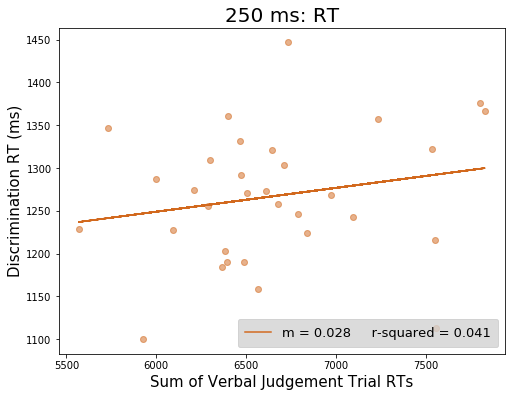

In [137]:
#run regression
plt.figure(figsize=[8,6])
RTsum_X_250 = np.array(all_VE_RTsum_250).reshape(-1,1)
VE_PC_250 = avg_RT_250
RTsum_PC_reg_250 = LinearRegression().fit(RTsum_X_250, VE_PC_250)

#Generated Predictions
RTsum_PC_predicted_250 = RTsum_PC_reg_250.predict(RTsum_X_250)
#Plot Our Actual and Predicted Values
plt.plot(RTsum_X_250, VE_PC_250, 'o', color='chocolate', alpha = 0.3);
plt.plot(RTsum_X_250, RTsum_PC_predicted_250,color='chocolate', label = 'm = ' + str(round(RTsum_PC_reg_250.coef_[0], 3))
         + '     r-squared = ' + str(round(float(RTsum_PC_reg_250.score(RTsum_X_250, VE_PC_250)), 3)))
plt.xlabel("Sum of Verbal Judgement Trial RTs", fontsize = 15)
plt.ylabel("Discrimination RT (ms)", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(RTsum_PC_reg_250.coef_))
print("b: {0}".format(RTsum_PC_reg_250.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", RTsum_PC_reg_250.score(RTsum_X_250, VE_PC_250))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("250 ms: RT", fontsize = 20)

m: [-0.01088484]
b: 1151.4563125193306
R-squared:  0.0195212680062411


Text(0.5, 1.0, '1000 ms: RT')

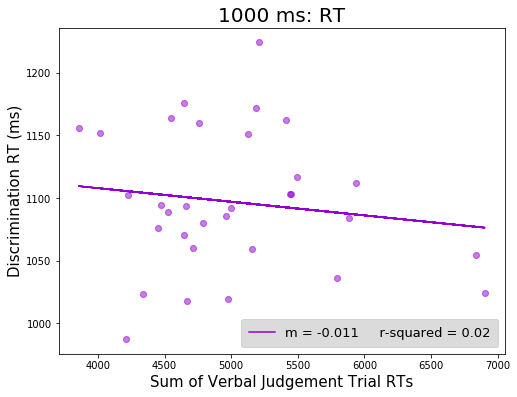

In [138]:
#run regression
plt.figure(figsize=[8,6])
RTsum_X_1000 = np.array(all_VE_RTsum_1000).reshape(-1,1)
VE_PC_1000 = avg_RT_1000
RTsum_PC_reg_1000 = LinearRegression().fit(RTsum_X_1000, VE_PC_1000)

#Generated Predictions
RTsum_PC_predicted_1000 = RTsum_PC_reg_1000.predict(RTsum_X_1000)
#Plot Our Actual and Predicted Values
plt.plot(RTsum_X_1000, VE_PC_1000, 'o', color='darkviolet', alpha = 0.3);
plt.plot(RTsum_X_1000, RTsum_PC_predicted_1000,color='darkviolet', label = 'm = ' + str(round(RTsum_PC_reg_1000.coef_[0], 3))
         + '     r-squared = ' + str(round(float(RTsum_PC_reg_1000.score(RTsum_X_1000, VE_PC_1000)), 3)))
plt.xlabel("Sum of Verbal Judgement Trial RTs", fontsize = 15)
plt.ylabel("Discrimination RT (ms)", fontsize = 15)

#get coefficients and y intercept
print("m: {0}".format(RTsum_PC_reg_1000.coef_))
print("b: {0}".format(RTsum_PC_reg_1000.intercept_))

#Returns the coefficient of determination R^2 of the prediction.
print("R-squared: ", RTsum_PC_reg_1000.score(RTsum_X_1000, VE_PC_1000))


legend = plt.legend(loc = 4, fontsize = 13, borderpad = 0.6, labelspacing = 1)
legend.get_frame().set_facecolor('lightgray')

plt.title("1000 ms: RT", fontsize = 20)